# Generating Inhibiotors for DENV MTase with ReLeaSE

In this experiment we optimize parameters of pretrained generative RNN to produce molecules with higher probability of being inhibitors against DENV MTase

values of logP within drug-like region according to Lipinsky rule. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learninf for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
#%matplotlib notebook

#Basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import seaborn as sns
import time

# Chemistry
from rdkit import Chem, DataStructs

# Initialize tqdm progress bar
from tqdm import tnrange, tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas(tqdm_notebook)

In [3]:
# CUDA / PyTorch
%env CUDA_VISIBLE_DEVICES=0
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

env: CUDA_VISIBLE_DEVICES=0


In [4]:
print("torch.cuda.is_available()          =", torch.cuda.is_available())
print("torch.cuda.device_count()          =", torch.cuda.device_count())
print("torch.cuda.current_device()        =", torch.cuda.current_device())
print("torch.cuda.device('cuda')          =", torch.cuda.device('cuda'))
print("torch.cuda.get_device_name()       =", torch.cuda.get_device_name(0))
print("torch.cuda.get_device_capability() =", torch.cuda.get_device_capability(0))

torch.cuda.is_available()          = True
torch.cuda.device_count()          = 1
torch.cuda.current_device()        = 0
torch.cuda.device('cuda')          = <torch.cuda.device object at 0x00000270478D8710>
torch.cuda.get_device_name()       = GeForce GTX 1060
torch.cuda.get_device_capability() = (6, 1)


In [5]:
# ReLeaSE
import sys
sys.path.append('./release/')
from release.stackRNN import StackAugmentedRNN
from release.data import GeneratorData
from release.utils import canonical_smiles, time_since

In [6]:
# My own utility functions
# The averaged random forest model
from MTase.ActivityClassifier import ActivityClassifier, AverageRF
from MTase.utils import train_test_split_data, evaluate_classifier_model

## Functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [7]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.0) & 
                                     (prediction <= 5.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted LogP', 
           title='Distribution of predicted LogP for generated molecules')
    plt.show()

### **Estimate and Update**

In [8]:
def estimate_and_update(generator, predictor, n_to_generate):
    """
    1) generates n_to_generate number of SMILES strings
    2) filters invalid SMILES
    3) predicts logP for valid SMILES
    4) plots histogram of predicted logP
    5) Returns unique and valid SMILES and their predicted logPs
    """
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

        
    #sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    #unique_smiles = list(np.unique(sanitized))[1:]

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)
    unique_smiles = list(np.unique(sanitized))
    
    if unique_smiles[0] == '':
        unique_smiles = unique_smiles[1:]

    #print(f"Generated {len(generated)} SMILES: \n", generated)
    #print(f"{len(sanitized)} Sanitized SMILES: \n", sanitized)
    #print(f"{len(unique_smiles)} Unique SMILES:\n", unique_smiles)
    
    n_valid = len(sanitized) - sanitized.count('')
    n_unique = len(unique_smiles)
    print(f"Valid SMILES : {n_valid} ({(n_valid / n_to_generate):0.2%} of the total)")
    print(f"Unique SMILES: {n_unique} ({(n_unique / n_to_generate):0.2%} of the total)")
    prediction = predictor.predict(unique_smiles)  
    #print("Predictions:", prediction)
    #plot_hist(prediction, n_to_generate)
    
    return unique_smiles, prediction

## Setting up the generator

### Loading data for the generator

Data from CHEMBL: a collection of 1,576,904 SMILES. This data will be used to train the SMILES generator.

In [9]:
gen_data_path = './release/data/chembl_22_clean_1576904_sorted_std_final.smi'

In [10]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [11]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [12]:
use_cuda = gen_data.use_cuda
print("use_cuda = ", use_cuda)

use_cuda =  True


In [13]:
gen_data.n_characters

45

In [14]:
len(tokens)

45

### Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./release/figures/generator.png">

Initialize stack-augmented generative RNN:

In [16]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

**To train the generator model from scratch, uncomment the lines below.**

Train the SMILES generator, using the `gen_data` defined above. The training is set to 1,500,000 iterations (epochs) which, in my computer (Acer Predator Helios 300 with 1 NVIDIA GEFORCE GTX 1060, 6GB memory), takes ~5h 54min ( approx. 6h), to run only 3% (47,726) of the total of 1,500,000 iterations.

For running all the iterations on my computer it would take ~12,000 minutes, or 200h.

In [ ]:
#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore")
#    losses = my_generator.fit(gen_data, 1500000)
#    losses = my_generator.fit(gen_data, 10)

In [ ]:
#plt.plot(losses)

In [ ]:
#my_generator.evaluate(gen_data)

In [ ]:
#my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [17]:
model_path = './release/checkpoints/generator/checkpoint_biggest_rnn'
my_generator.load_model(model_path)

## Setting up the predictor (AverageRFClassifier)

We want to generate molecules that are *active* inhibitors against DENV MTase. Out predictor will be a simple classifier that will only separate actives* from *inactives*. The classifier will be a set of 5 RandomForests trained in a 5-fold cross validation manner.

### Data
The classifier will be trained on data from the experiment

In [18]:
active = pd.read_pickle("./active.pkl.bz2")
inactive = pd.read_pickle("./inactive.pkl.bz2")

# Add active bit for classification tasks
active['ActiveBit']   = True
inactive['ActiveBit'] = False

# Prepare a DataFrame with only the data we need
columns = ['PUBCHEM_SID', 'RDKit Fingerprints', 'ActiveBit']
data = pd.concat([active.filter(columns,axis=1),inactive],
                 axis=0,join='inner', ignore_index=True)

In [19]:
# Prepare the data for training
X_data  = np.array(list(data['RDKit Fingerprints'])).astype(int)
y_data = data['ActiveBit'].values

# Split in train / test sets
X_train, X_test, y_train, y_test = train_test_split_data(X_data, y_data, rate_inactives=0.90)

X_train:  7461 	y_train:  7461 	( 746 actives and 6715 inactives)
X_test:   829  	y_test:   829  	( 83 actives and 746 inactives)


### Fit the Classifier

In [20]:
classifier = AverageRF(model_type='classifier',n_forests=5, verbosity=1, 
                         bootstrap=True, class_weight='balanced_subsample',
                         criterion='entropy', max_features=0.33, n_estimators=150,
                         n_jobs=4, random_state=42, verbose=0)

Training the Classifier with 8290 molecules, i.e., 10*n_actives

In [21]:
n_molecules = 8290
classifier.fit(X_data[:n_molecules],y_data[:n_molecules])

SPLIT: 0  [TRAIN: 6631 	TEST: 1659] 	 Training Time:16.066 seconds.
Confusion Matrix = 
 [[1480   13]
 [  95   71]]
	  Precision = 0.8452
	  Recall    = 0.4277
	  F1-score  = 0.5680
	  ROC AUC   = 0.9396
	  Score     = 0.9349 

SPLIT: 1  [TRAIN: 6632 	TEST: 1658] 	 Training Time:15.359 seconds.
Confusion Matrix = 
 [[1475   17]
 [ 104   62]]
	  Precision = 0.7848
	  Recall    = 0.3735
	  F1-score  = 0.5061
	  ROC AUC   = 0.9203
	  Score     = 0.9270 

SPLIT: 2  [TRAIN: 6632 	TEST: 1658] 	 Training Time:16.269 seconds.
Confusion Matrix = 
 [[1474   18]
 [  94   72]]
	  Precision = 0.8000
	  Recall    = 0.4337
	  F1-score  = 0.5625
	  ROC AUC   = 0.9221
	  Score     = 0.9324 

SPLIT: 3  [TRAIN: 6632 	TEST: 1658] 	 Training Time:16.578 seconds.
Confusion Matrix = 
 [[1472   20]
 [  98   68]]
	  Precision = 0.7727
	  Recall    = 0.4096
	  F1-score  = 0.5354
	  ROC AUC   = 0.9170
	  Score     = 0.9288 

SPLIT: 4  [TRAIN: 6633 	TEST: 1657] 	 Training Time:15.863 seconds.
Confusion Matrix = 


In [22]:
my_predictor = ActivityClassifier(classifier=classifier, fp_type='rdkit')

## Create Unbiased distribution

Here we produce an unbiased distribution of molecules. In the end, this can be compared to the distribution generated after reinforcement.

In [23]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                               my_predictor,
                                                               n_to_generate=10000)


Valid SMILES : 7676 (76.76% of the total)
Unique SMILES: 7666 (76.66% of the total)


(array([1.333e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.304e+03, 9.970e+02, 2.800e+01, 4.000e+00]),
 array([-1.        , -0.83987919, -0.67975838, -0.51963758, -0.35951677,
        -0.19939596, -0.03927515,  0.12084566,  0.28096647,  0.44108727,
         0.60120808]),
 <a list of 10 Patch objects>)

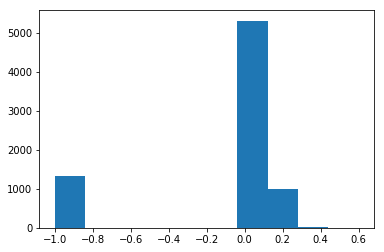

In [24]:
plt.hist(prediction_unbiased)

In [26]:
len(smiles_unbiased), len(prediction_unbiased)

(7666, 7666)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./release/figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Functions

In [28]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

### Reinforcement Learning

#### Reward function
The reward function we will use here is the following:

$$
R =  \begin{cases} 11.0, & \mbox{if } 1.0 < \log P < 4.0 \\ 1.0, & \mbox{otherwise}  \end{cases}
$$

In [29]:
def get_reward_activity(smiles, predictor, threshold=0.1):
    proba = predictor.predict(smiles)
    if proba >= threshold:
        return 12
    else:
        return 1.0

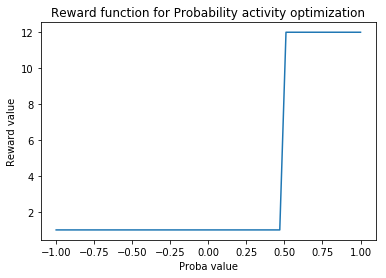

In [30]:
x = np.linspace(-1, 1)
reward = lambda x: 12 if x > 0.5 else 1.0
plt.plot(x, [reward(i) for i in x])
plt.xlabel('Proba value')
plt.ylabel('Reward value')
plt.title('Reward function for Probability activity optimization')
plt.show()

#### The Reinforced Learner

In [31]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [41]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [42]:
RL_activity = Reinforcement(my_generator_max, my_predictor, get_reward_activity)

#### Supervised learning set-up
Here, we will combine reinforcement with supervised learning. 
First, we will create a list of the 'best' molecules generated by the unbiased generator, then use them to bias the generator.

In [43]:
# Get the n_best molecules generated by the unbiased generator
n_best = 100

best = np.argsort(-np.array(prediction_unbiased))[:n_best]
best_smiles_unbiased = []
best_predictions_unbiased = []

for molecule in best:
    best_smiles_unbiased.append('<'+smiles_unbiased[molecule]+'>')
    best_predictions_unbiased.append(prediction_unbiased[molecule])

# Now, reset the gen_data.file to hold those n_best molecules
gen_data.file = best_smiles_unbiased
gen_data.file_len = len(best_smiles_unbiased)

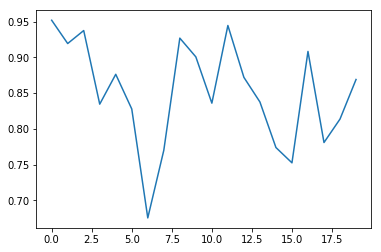

In [44]:
# Bias the generator for 100 iterations towards the best molecules
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    losses = RL_activity.generator.fit(gen_data, 100)
plt.plot(losses)

#### Reinforcement loop
This is the main loop, the heart of the program.

In [45]:
rw_args = {"threshold": 0.1}
thresh_limit = 0.90
best100_smiles  = []
best100_rewards = []
rewards = []
rl_losses = []

# Keep a history per iteration
history_thresh = []
history_junk   = []
history_newmol = []
history_above  = []
history_smiles = []
history_pred   = []

junk_rate   = []
thr_changes = []



------------------------------------------------------------
Iteration 0 of 100. Threshold = 0.100
------------------------------------------------------------


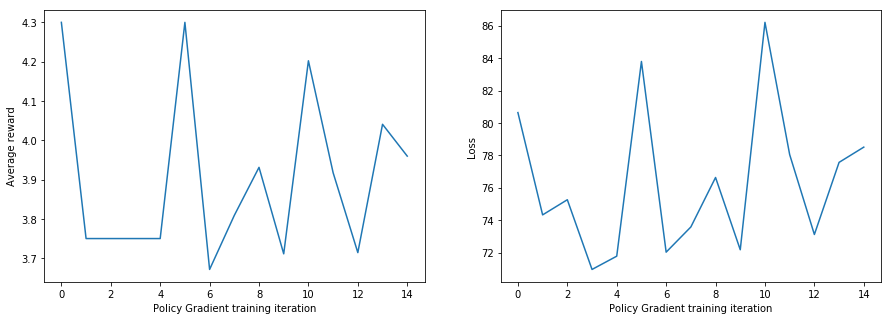

Junk: 30 out of 152, 	 junk_rate = 19.7%

Threshold: 0.1
Found 31 molecules above threshold (19.08%).
Number of new molecules simce last training: 31
Saving checkpoint...
Iteration fininshed. Elapsed time: 232.428 sec.


------------------------------------------------------------
Iteration 1 of 100. Threshold = 0.100
------------------------------------------------------------


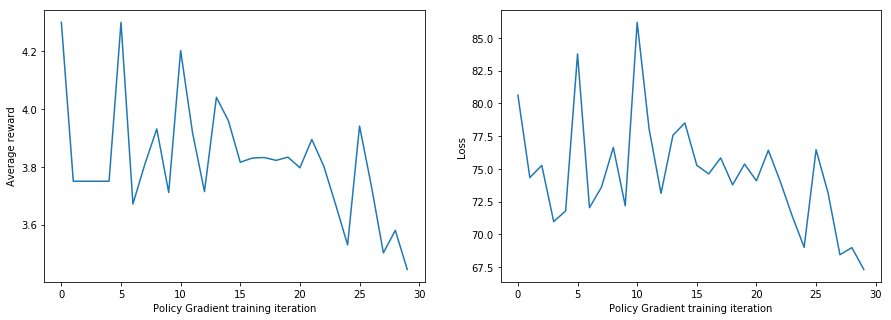

Junk: 30 out of 149, 	 junk_rate = 20.1%

Threshold: 0.1
Found 39 molecules above threshold (26.17%).
Number of new molecules simce last training: 70
Iteration fininshed. Elapsed time: 229.790 sec.


------------------------------------------------------------
Iteration 2 of 100. Threshold = 0.100
------------------------------------------------------------


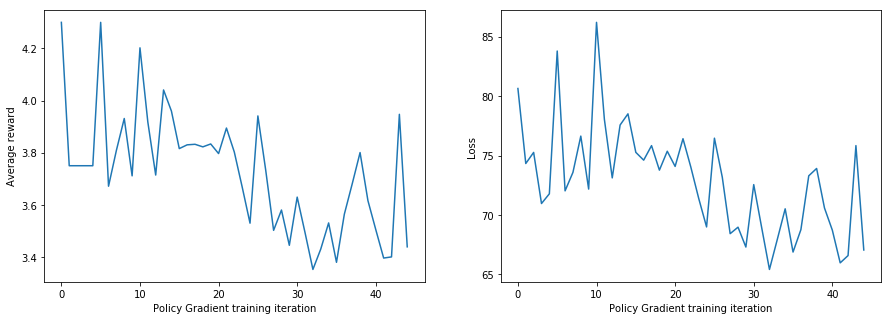

Junk: 30 out of 148, 	 junk_rate = 20.3%

Threshold: 0.1
Found 37 molecules above threshold (25.00%).
Number of new molecules simce last training: 107


Iteration fininshed. Elapsed time: 275.930 sec.


------------------------------------------------------------
Iteration 3 of 100. Threshold = 0.100
------------------------------------------------------------


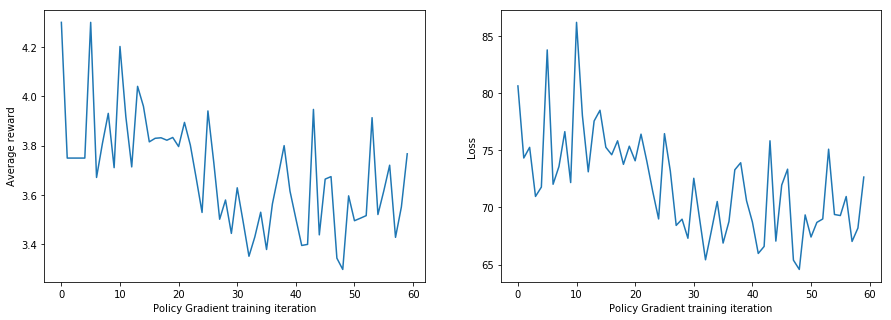

Junk: 27 out of 150, 	 junk_rate = 18.0%

Threshold: 0.1
Found 41 molecules above threshold (26.00%).
Number of new molecules simce last training: 41
Iteration fininshed. Elapsed time: 226.768 sec.


------------------------------------------------------------
Iteration 4 of 100. Threshold = 0.100
------------------------------------------------------------


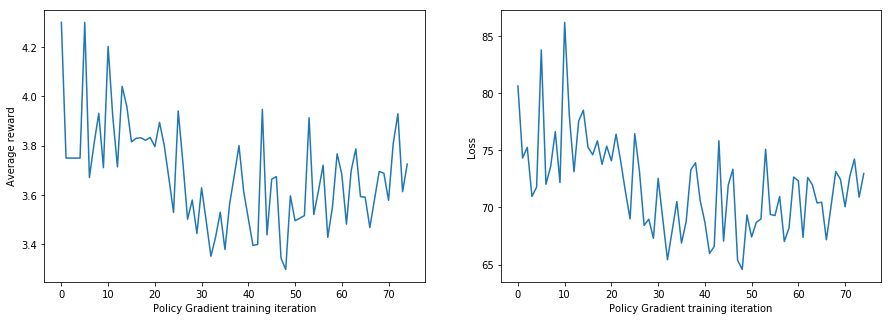

Junk: 31 out of 147, 	 junk_rate = 21.1%

Threshold: 0.1
Found 42 molecules above threshold (28.57%).
Number of new molecules simce last training: 83
Iteration fininshed. Elapsed time: 231.176 sec.


------------------------------------------------------------
Iteration 5 of 100. Threshold = 0.100
------------------------------------------------------------


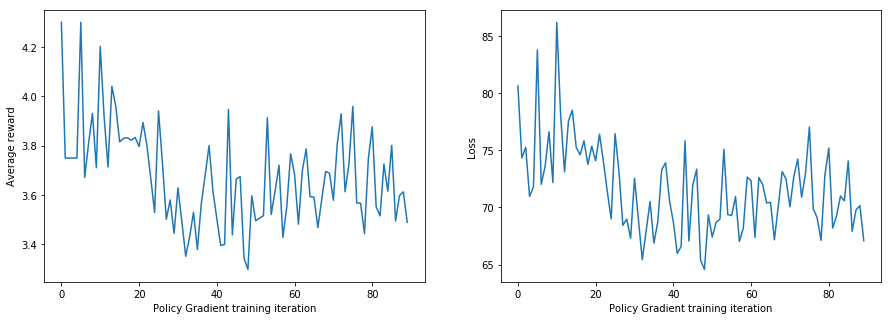

Junk: 23 out of 140, 	 junk_rate = 16.4%

Threshold: 0.1
Found 49 molecules above threshold (34.29%).
Adjusting threshold to 0.11 for next iteration.
Number of new molecules simce last training: 132


Iteration fininshed. Elapsed time: 267.864 sec.


------------------------------------------------------------
Iteration 6 of 100. Threshold = 0.110
------------------------------------------------------------


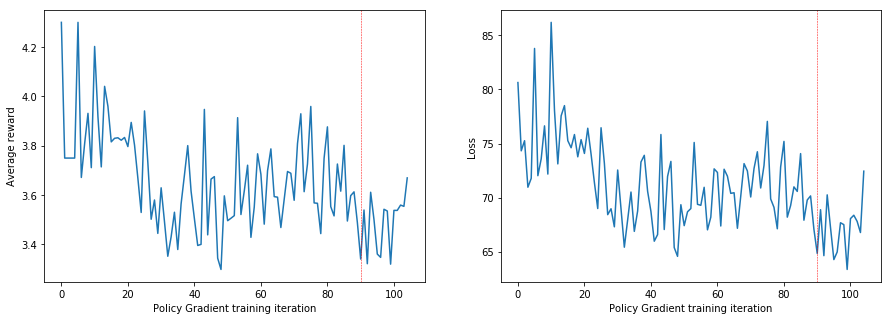

Junk: 30 out of 137, 	 junk_rate = 21.9%

Threshold: 0.11
Found 36 molecules above threshold (26.28%).
Number of new molecules simce last training: 36
Iteration fininshed. Elapsed time: 218.803 sec.


------------------------------------------------------------
Iteration 7 of 100. Threshold = 0.110
------------------------------------------------------------


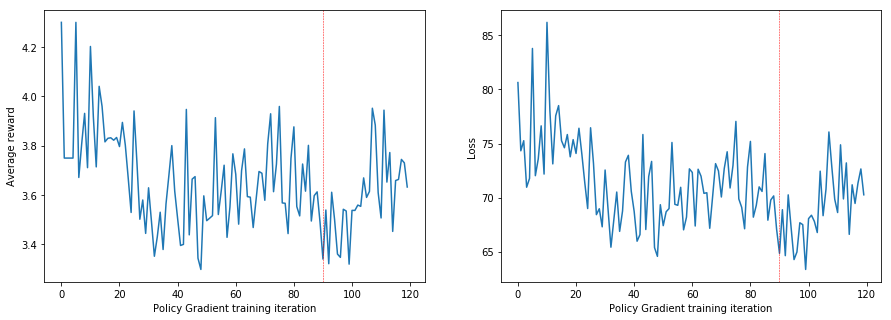

Junk: 23 out of 143, 	 junk_rate = 16.1%

Threshold: 0.11
Found 52 molecules above threshold (36.36%).
Adjusting threshold to 0.121 for next iteration.
Number of new molecules simce last training: 88
Iteration fininshed. Elapsed time: 229.736 sec.


------------------------------------------------------------
Iteration 8 of 100. Threshold = 0.121
------------------------------------------------------------


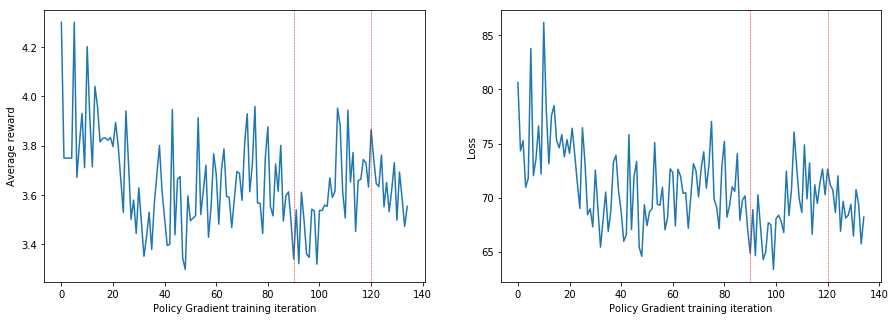

Junk: 27 out of 138, 	 junk_rate = 19.6%

Threshold: 0.121
Found 37 molecules above threshold (26.81%).
Number of new molecules simce last training: 125


Iteration fininshed. Elapsed time: 275.207 sec.


------------------------------------------------------------
Iteration 9 of 100. Threshold = 0.121
------------------------------------------------------------


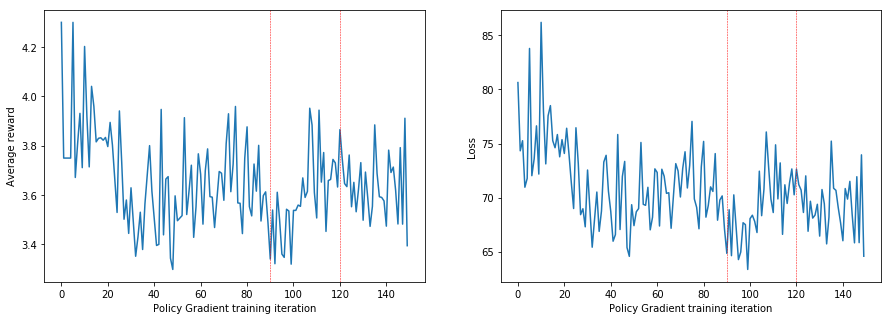

Junk: 36 out of 151, 	 junk_rate = 23.8%

Threshold: 0.121
Found 45 molecules above threshold (29.80%).
Number of new molecules simce last training: 45
Iteration fininshed. Elapsed time: 227.787 sec.


------------------------------------------------------------
Iteration 10 of 100. Threshold = 0.121
------------------------------------------------------------


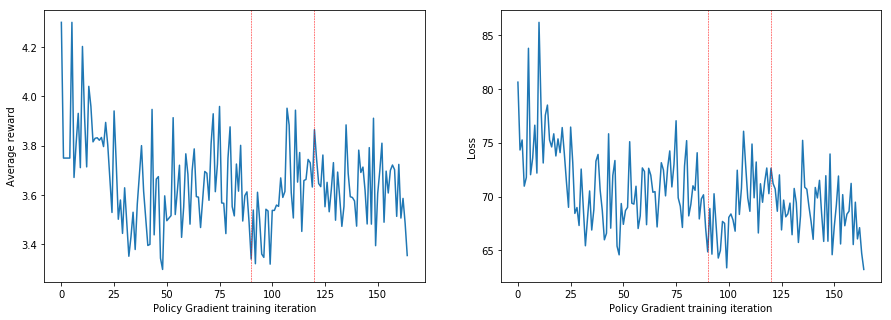

Junk: 37 out of 145, 	 junk_rate = 25.5%

Threshold: 0.121
Found 53 molecules above threshold (36.55%).
Adjusting threshold to 0.1331 for next iteration.
Number of new molecules simce last training: 98
Saving checkpoint...
Iteration fininshed. Elapsed time: 222.120 sec.


------------------------------------------------------------
Iteration 11 of 100. Threshold = 0.133
------------------------------------------------------------


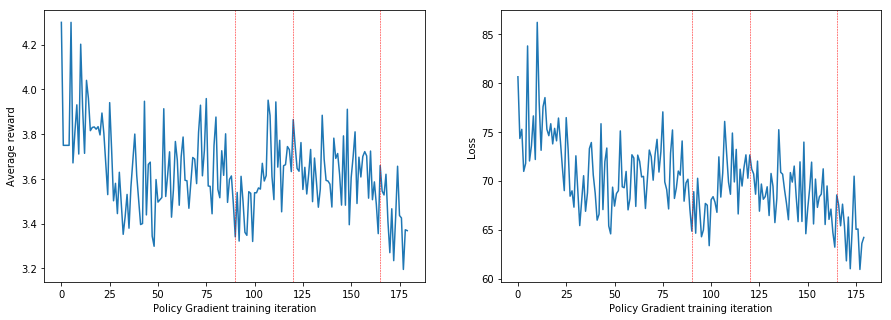

Junk: 22 out of 137, 	 junk_rate = 16.1%

Threshold: 0.1331
Found 36 molecules above threshold (26.28%).
Number of new molecules simce last training: 134


Iteration fininshed. Elapsed time: 276.954 sec.


------------------------------------------------------------
Iteration 12 of 100. Threshold = 0.133
------------------------------------------------------------


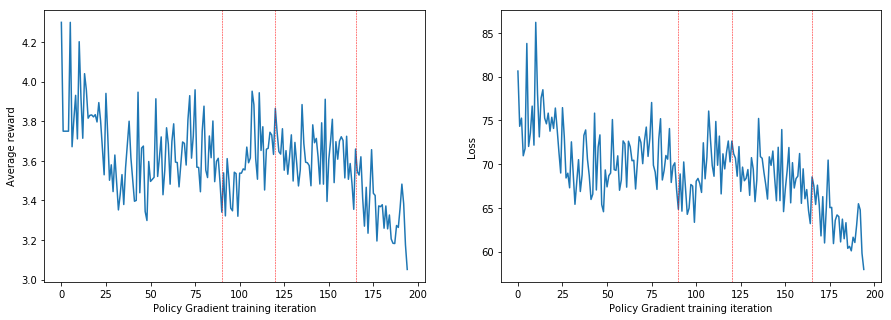

Junk: 25 out of 144, 	 junk_rate = 17.4%

Threshold: 0.1331
Found 45 molecules above threshold (31.25%).
Adjusting threshold to 0.14641 for next iteration.
Number of new molecules simce last training: 45
Iteration fininshed. Elapsed time: 229.901 sec.


------------------------------------------------------------
Iteration 13 of 100. Threshold = 0.146
------------------------------------------------------------


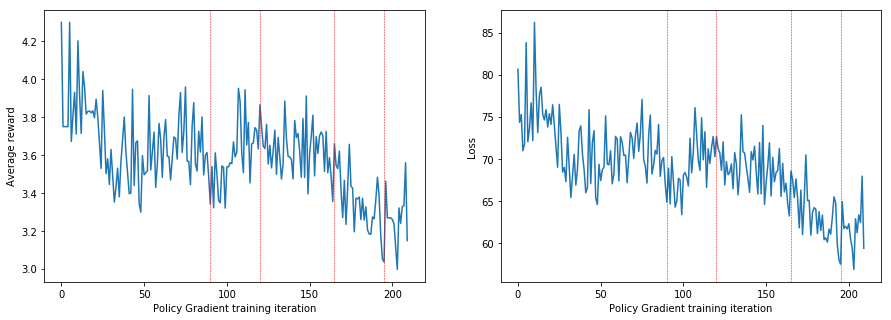

Junk: 27 out of 140, 	 junk_rate = 19.3%

Threshold: 0.14641
Found 40 molecules above threshold (28.57%).
Number of new molecules simce last training: 85
Iteration fininshed. Elapsed time: 228.278 sec.


------------------------------------------------------------
Iteration 14 of 100. Threshold = 0.146
------------------------------------------------------------


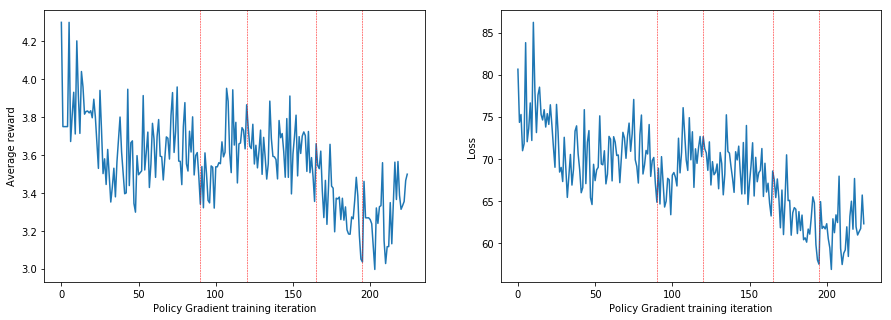

Junk: 22 out of 129, 	 junk_rate = 17.1%

Threshold: 0.14641
Found 35 molecules above threshold (27.13%).
Number of new molecules simce last training: 120


Iteration fininshed. Elapsed time: 273.074 sec.


------------------------------------------------------------
Iteration 15 of 100. Threshold = 0.146
------------------------------------------------------------


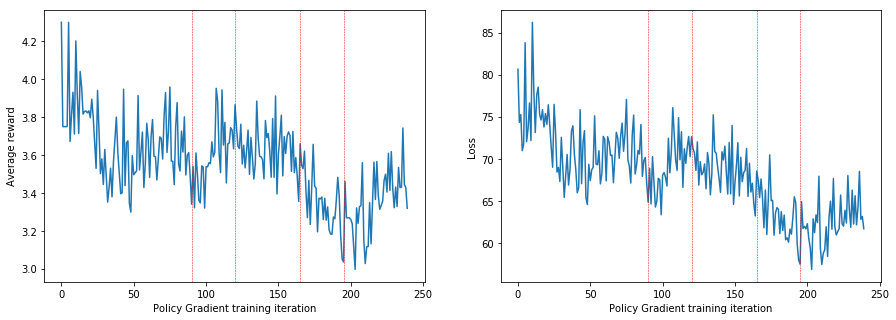

Junk: 28 out of 147, 	 junk_rate = 19.0%

Threshold: 0.14641
Found 54 molecules above threshold (36.73%).
Adjusting threshold to 0.16105 for next iteration.
Number of new molecules simce last training: 54
Iteration fininshed. Elapsed time: 231.511 sec.


------------------------------------------------------------
Iteration 16 of 100. Threshold = 0.161
------------------------------------------------------------


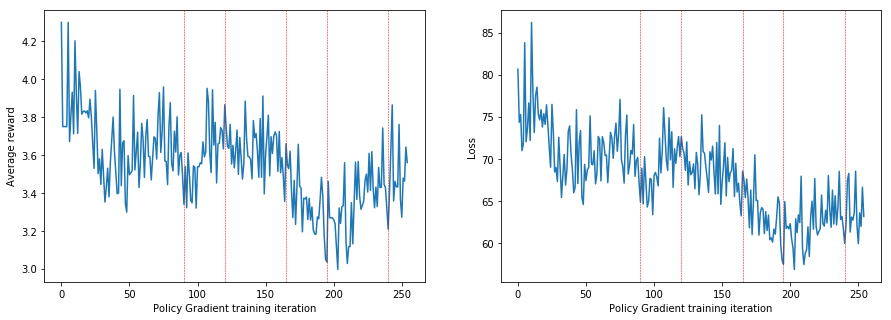

Junk: 36 out of 147, 	 junk_rate = 24.5%

Threshold: 0.16105
Found 36 molecules above threshold (24.49%).
Number of new molecules simce last training: 90
Iteration fininshed. Elapsed time: 223.133 sec.


------------------------------------------------------------
Iteration 17 of 100. Threshold = 0.161
------------------------------------------------------------


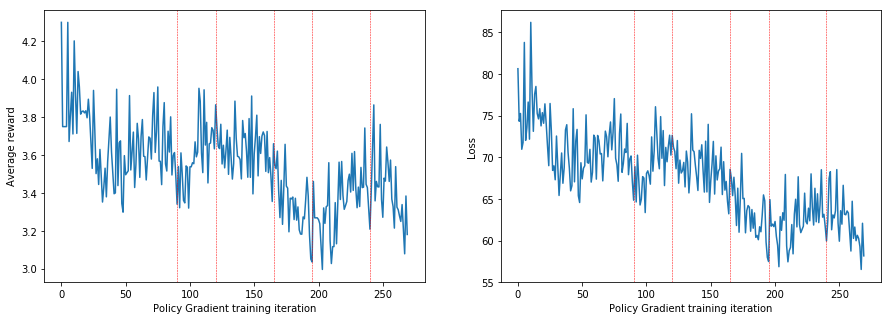

Junk: 32 out of 150, 	 junk_rate = 21.3%

Threshold: 0.16105
Found 39 molecules above threshold (26.00%).
Number of new molecules simce last training: 129


Iteration fininshed. Elapsed time: 277.201 sec.


------------------------------------------------------------
Iteration 18 of 100. Threshold = 0.161
------------------------------------------------------------


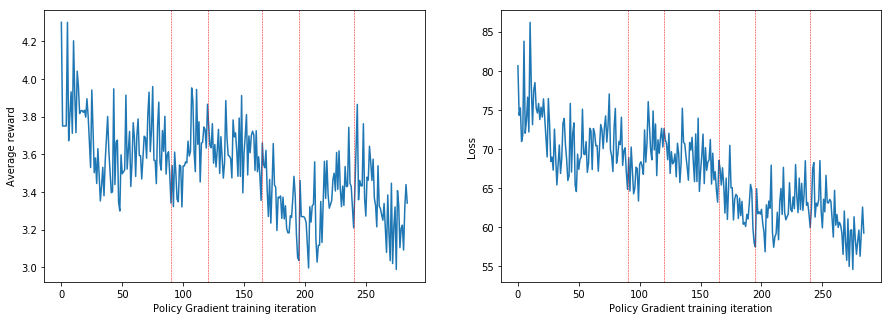

Junk: 27 out of 144, 	 junk_rate = 18.8%

Threshold: 0.16105
Found 39 molecules above threshold (27.08%).
Number of new molecules simce last training: 39
Iteration fininshed. Elapsed time: 223.413 sec.


------------------------------------------------------------
Iteration 19 of 100. Threshold = 0.161
------------------------------------------------------------


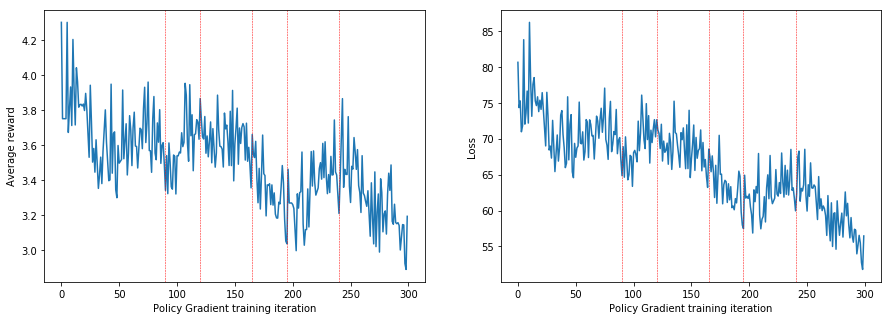

Junk: 31 out of 134, 	 junk_rate = 23.1%

Threshold: 0.16105
Found 31 molecules above threshold (23.13%).
Number of new molecules simce last training: 70
Iteration fininshed. Elapsed time: 210.201 sec.


------------------------------------------------------------
Iteration 20 of 100. Threshold = 0.161
------------------------------------------------------------


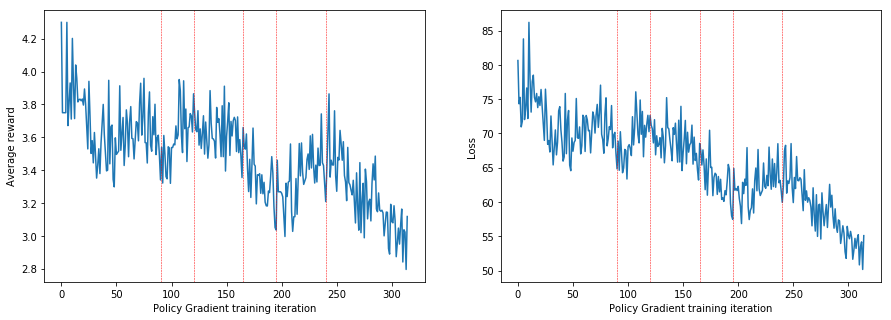

Junk: 23 out of 141, 	 junk_rate = 16.3%

Threshold: 0.16105
Found 54 molecules above threshold (38.30%).
Adjusting threshold to 0.17716 for next iteration.
Number of new molecules simce last training: 124


Saving checkpoint...
Iteration fininshed. Elapsed time: 276.860 sec.


------------------------------------------------------------
Iteration 21 of 100. Threshold = 0.177
------------------------------------------------------------


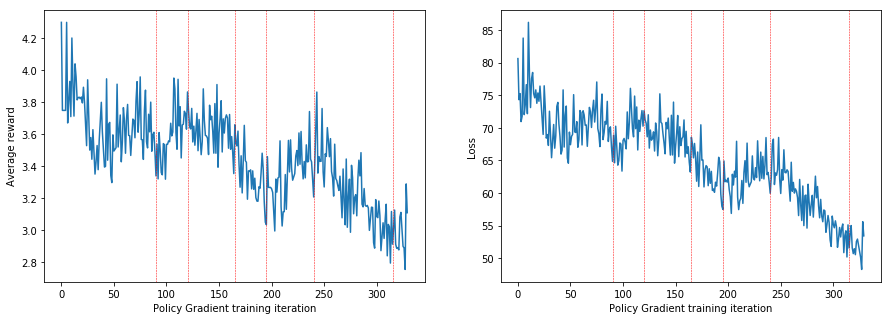

Junk: 34 out of 147, 	 junk_rate = 23.1%

Threshold: 0.17716
Found 49 molecules above threshold (33.33%).
Adjusting threshold to 0.19487 for next iteration.
Number of new molecules simce last training: 49
Iteration fininshed. Elapsed time: 224.310 sec.


------------------------------------------------------------
Iteration 22 of 100. Threshold = 0.195
------------------------------------------------------------


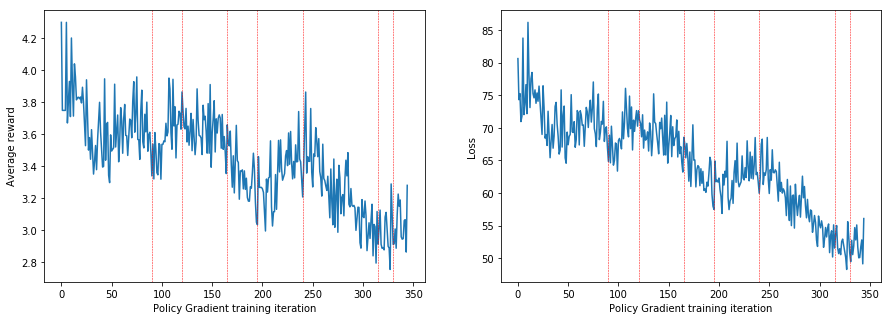

Junk: 36 out of 147, 	 junk_rate = 24.5%

Threshold: 0.19487
Found 27 molecules above threshold (18.37%).
Number of new molecules simce last training: 76
Iteration fininshed. Elapsed time: 221.906 sec.


------------------------------------------------------------
Iteration 23 of 100. Threshold = 0.195
------------------------------------------------------------


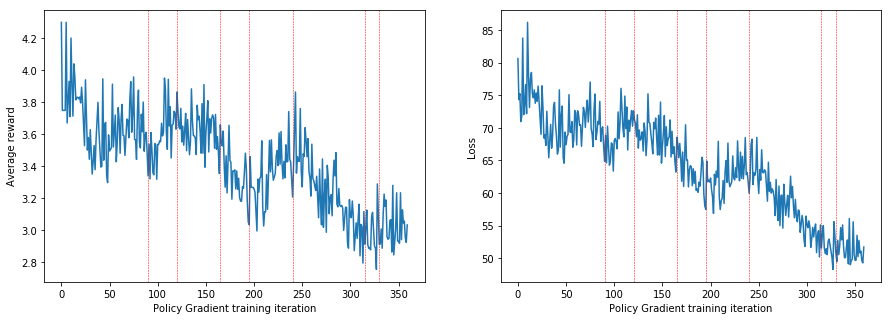

Junk: 34 out of 146, 	 junk_rate = 23.3%

Threshold: 0.19487
Found 28 molecules above threshold (19.18%).
Number of new molecules simce last training: 104


Iteration fininshed. Elapsed time: 272.267 sec.


------------------------------------------------------------
Iteration 24 of 100. Threshold = 0.195
------------------------------------------------------------


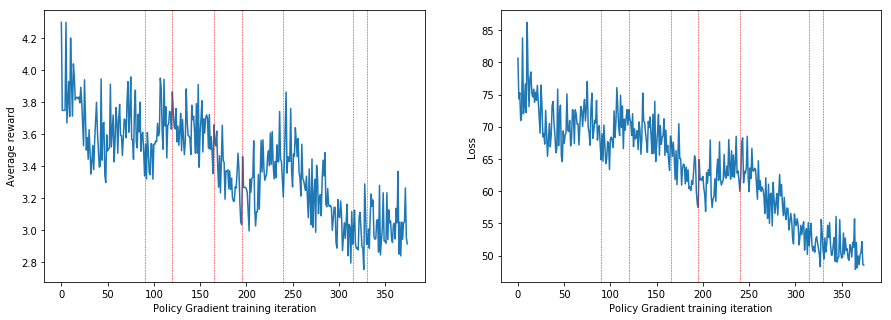

Junk: 33 out of 150, 	 junk_rate = 22.0%

Threshold: 0.19487
Found 39 molecules above threshold (26.00%).
Number of new molecules simce last training: 39
Iteration fininshed. Elapsed time: 224.215 sec.


------------------------------------------------------------
Iteration 25 of 100. Threshold = 0.195
------------------------------------------------------------


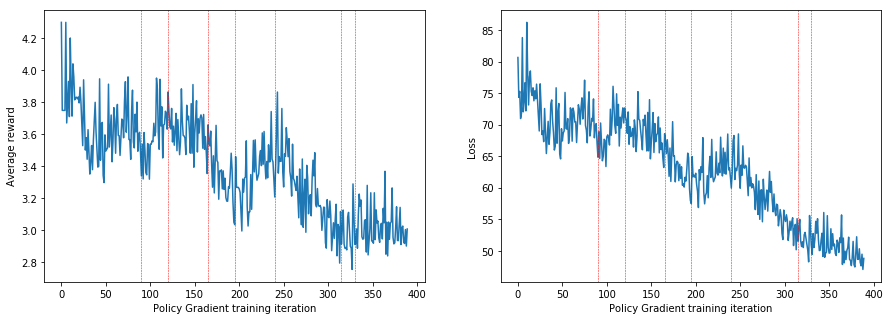

Junk: 33 out of 144, 	 junk_rate = 22.9%

Threshold: 0.19487
Found 35 molecules above threshold (24.31%).
Number of new molecules simce last training: 74
Iteration fininshed. Elapsed time: 222.921 sec.


------------------------------------------------------------
Iteration 26 of 100. Threshold = 0.195
------------------------------------------------------------


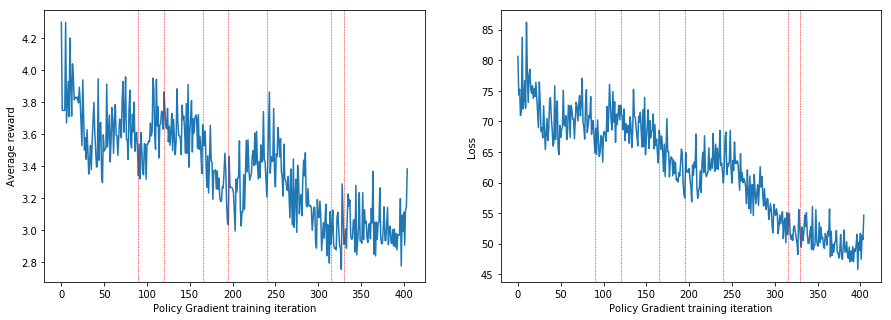

Junk: 24 out of 152, 	 junk_rate = 15.8%

Threshold: 0.19487
Found 46 molecules above threshold (30.26%).
Adjusting threshold to 0.21436 for next iteration.
Number of new molecules simce last training: 120


Iteration fininshed. Elapsed time: 282.700 sec.


------------------------------------------------------------
Iteration 27 of 100. Threshold = 0.214
------------------------------------------------------------


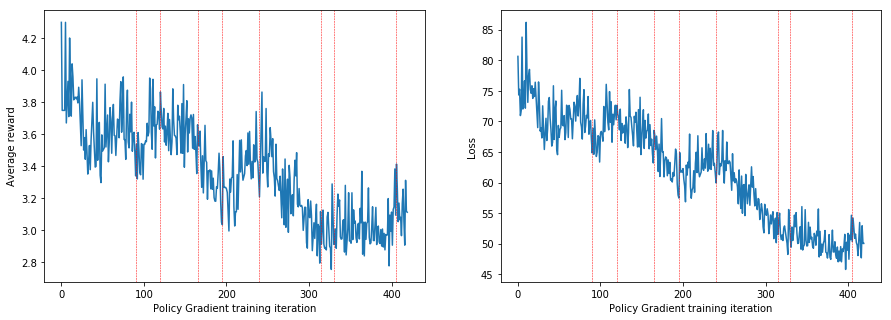

Junk: 30 out of 138, 	 junk_rate = 21.7%

Threshold: 0.21436
Found 38 molecules above threshold (27.54%).
Number of new molecules simce last training: 38
Iteration fininshed. Elapsed time: 223.156 sec.


------------------------------------------------------------
Iteration 28 of 100. Threshold = 0.214
------------------------------------------------------------


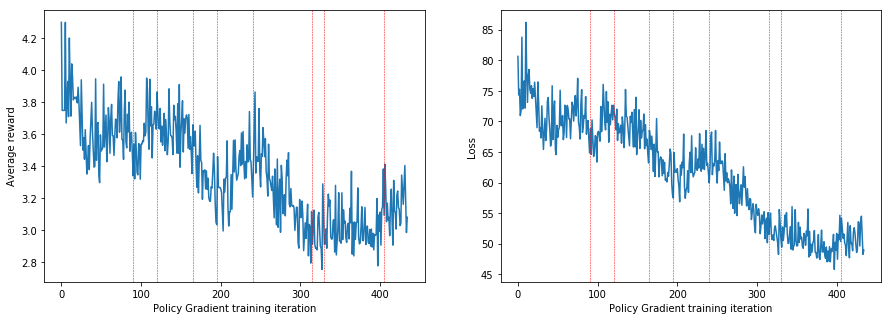

Junk: 33 out of 147, 	 junk_rate = 22.4%

Threshold: 0.21436
Found 40 molecules above threshold (27.21%).
Number of new molecules simce last training: 78
Iteration fininshed. Elapsed time: 224.417 sec.


------------------------------------------------------------
Iteration 29 of 100. Threshold = 0.214
------------------------------------------------------------


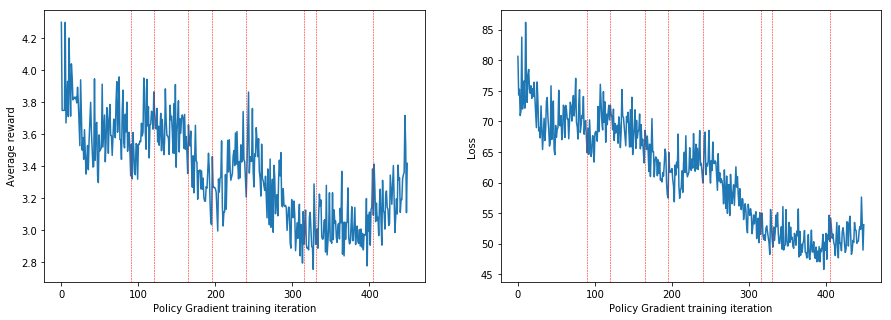

Junk: 27 out of 148, 	 junk_rate = 18.2%

Threshold: 0.21436
Found 45 molecules above threshold (30.41%).
Adjusting threshold to 0.23579 for next iteration.
Number of new molecules simce last training: 123


Iteration fininshed. Elapsed time: 283.535 sec.


------------------------------------------------------------
Iteration 30 of 100. Threshold = 0.236
------------------------------------------------------------


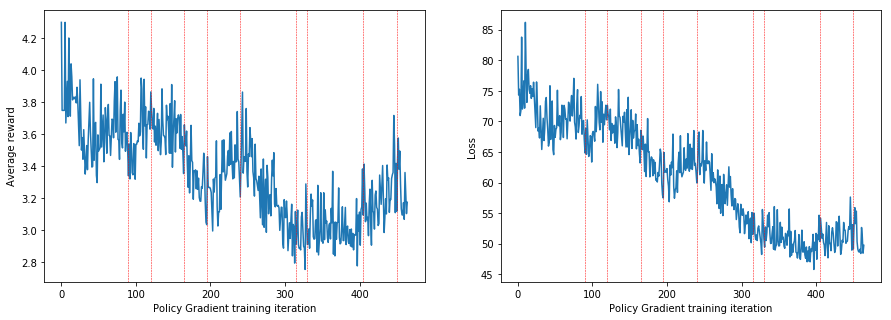

Junk: 26 out of 151, 	 junk_rate = 17.2%

Threshold: 0.23579
Found 46 molecules above threshold (30.46%).
Adjusting threshold to 0.25937 for next iteration.
Number of new molecules simce last training: 46
Saving checkpoint...
Iteration fininshed. Elapsed time: 237.232 sec.


------------------------------------------------------------
Iteration 31 of 100. Threshold = 0.259
------------------------------------------------------------


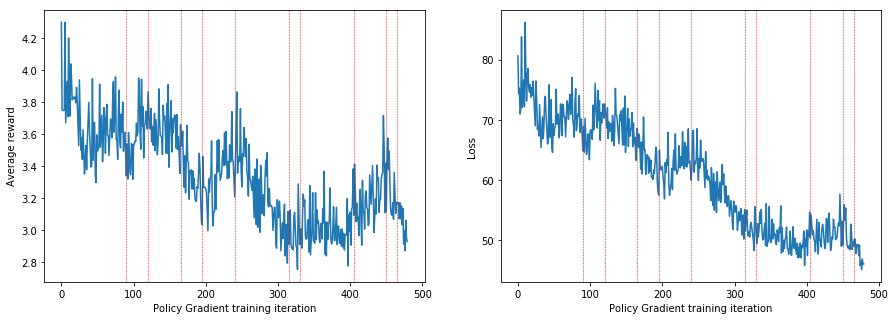

Junk: 28 out of 155, 	 junk_rate = 18.1%

Threshold: 0.25937
Found 31 molecules above threshold (20.00%).
Number of new molecules simce last training: 77
Iteration fininshed. Elapsed time: 241.523 sec.


------------------------------------------------------------
Iteration 32 of 100. Threshold = 0.259
------------------------------------------------------------


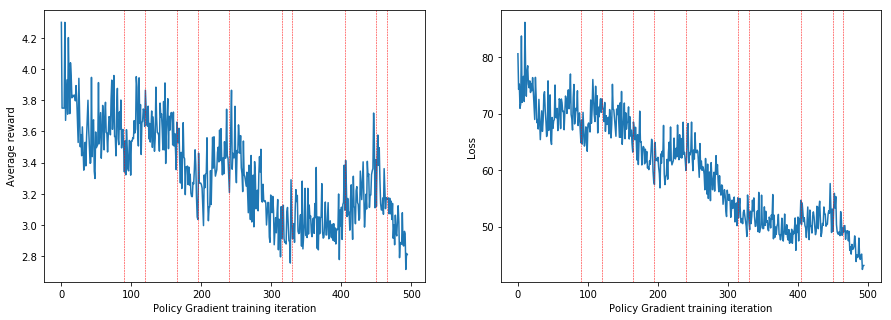

Junk: 21 out of 140, 	 junk_rate = 15.0%

Threshold: 0.25937
Found 30 molecules above threshold (21.43%).
Number of new molecules simce last training: 107


Iteration fininshed. Elapsed time: 287.066 sec.


------------------------------------------------------------
Iteration 33 of 100. Threshold = 0.259
------------------------------------------------------------


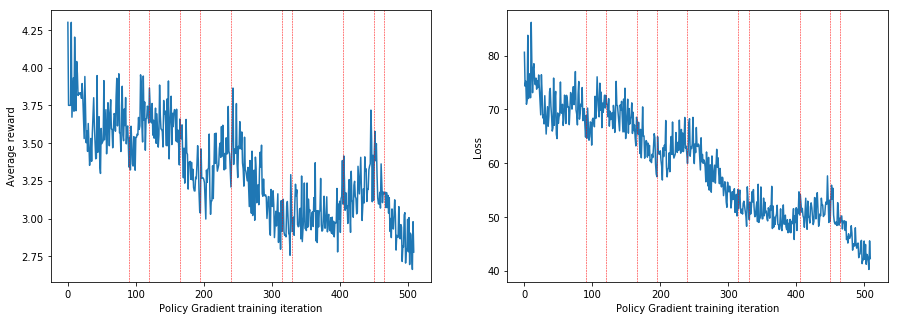

Junk: 33 out of 156, 	 junk_rate = 21.2%

Threshold: 0.25937
Found 40 molecules above threshold (25.64%).
Number of new molecules simce last training: 40
Iteration fininshed. Elapsed time: 234.409 sec.


------------------------------------------------------------
Iteration 34 of 100. Threshold = 0.259
------------------------------------------------------------


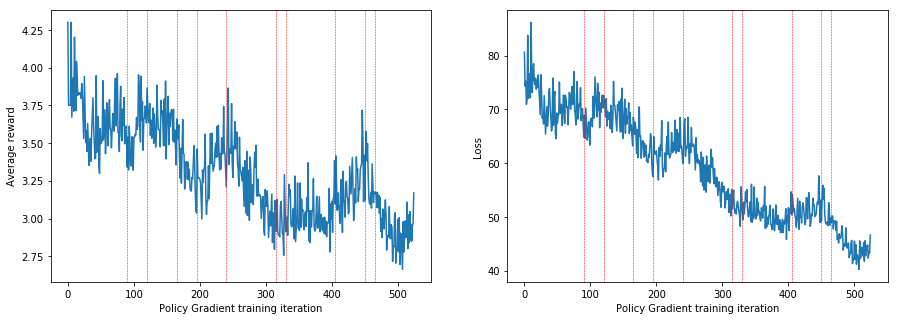

Junk: 32 out of 147, 	 junk_rate = 21.8%

Threshold: 0.25937
Found 43 molecules above threshold (29.25%).
Number of new molecules simce last training: 83
Iteration fininshed. Elapsed time: 239.426 sec.


------------------------------------------------------------
Iteration 35 of 100. Threshold = 0.259
------------------------------------------------------------


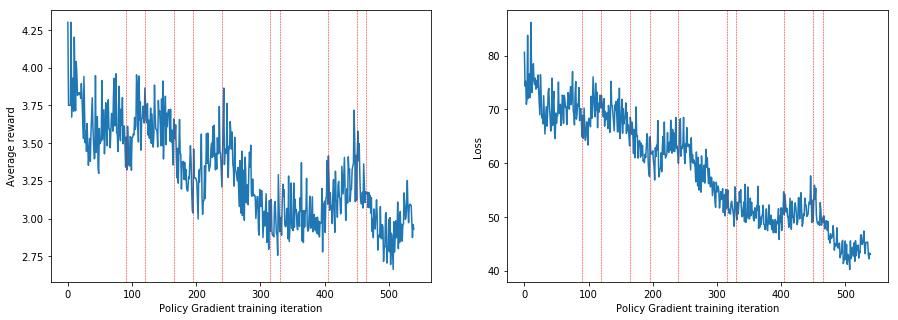

Junk: 25 out of 148, 	 junk_rate = 16.9%

Threshold: 0.25937
Found 50 molecules above threshold (33.78%).
Adjusting threshold to 0.28531 for next iteration.
Number of new molecules simce last training: 133


Iteration fininshed. Elapsed time: 290.060 sec.


------------------------------------------------------------
Iteration 36 of 100. Threshold = 0.285
------------------------------------------------------------


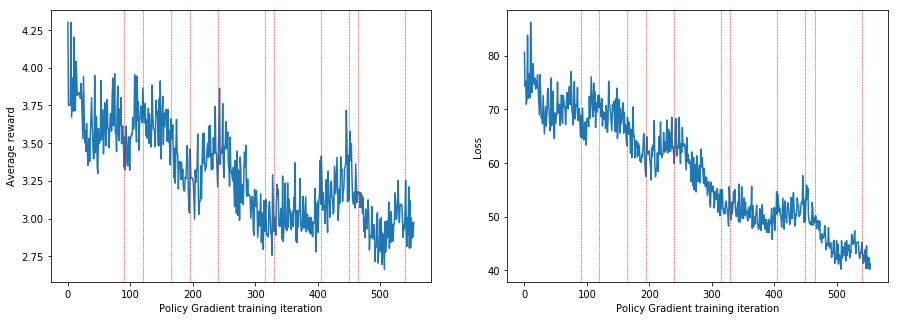

Junk: 26 out of 152, 	 junk_rate = 17.1%

Threshold: 0.28531
Found 27 molecules above threshold (17.76%).
Number of new molecules simce last training: 27
Iteration fininshed. Elapsed time: 244.762 sec.


------------------------------------------------------------
Iteration 37 of 100. Threshold = 0.285
------------------------------------------------------------


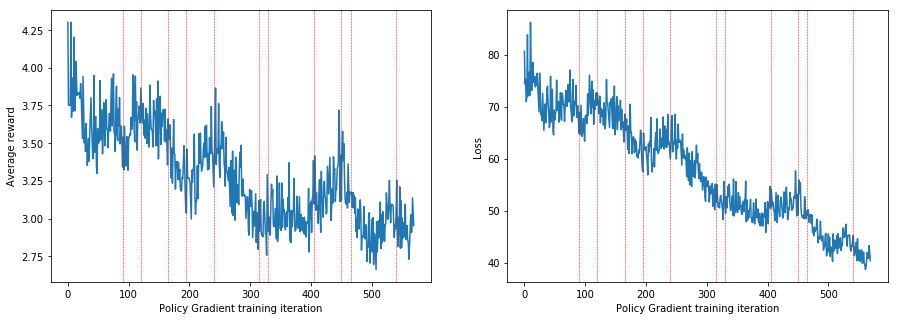

Junk: 34 out of 156, 	 junk_rate = 21.8%

Threshold: 0.28531
Found 36 molecules above threshold (23.08%).
Number of new molecules simce last training: 63
Iteration fininshed. Elapsed time: 243.707 sec.


------------------------------------------------------------
Iteration 38 of 100. Threshold = 0.285
------------------------------------------------------------


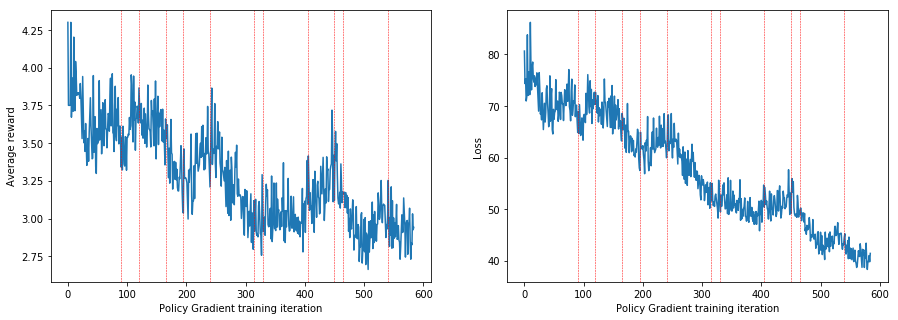

Junk: 30 out of 161, 	 junk_rate = 18.6%

Threshold: 0.28531
Found 39 molecules above threshold (24.22%).
Number of new molecules simce last training: 102


Iteration fininshed. Elapsed time: 307.034 sec.


------------------------------------------------------------
Iteration 39 of 100. Threshold = 0.285
------------------------------------------------------------


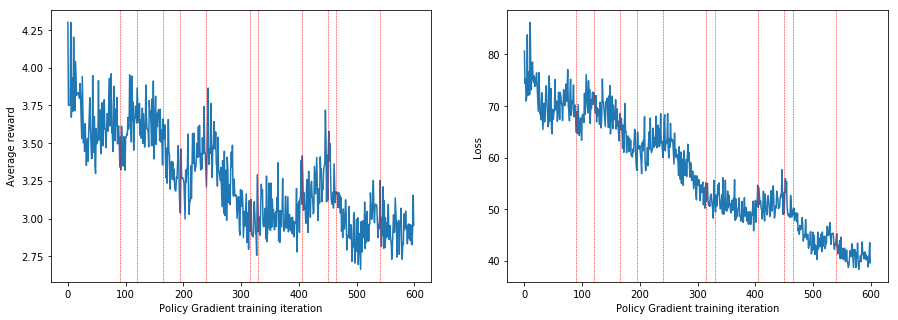

Junk: 29 out of 155, 	 junk_rate = 18.7%

Threshold: 0.28531
Found 52 molecules above threshold (33.55%).
Adjusting threshold to 0.31384 for next iteration.
Number of new molecules simce last training: 52
Iteration fininshed. Elapsed time: 240.973 sec.


------------------------------------------------------------
Iteration 40 of 100. Threshold = 0.314
------------------------------------------------------------


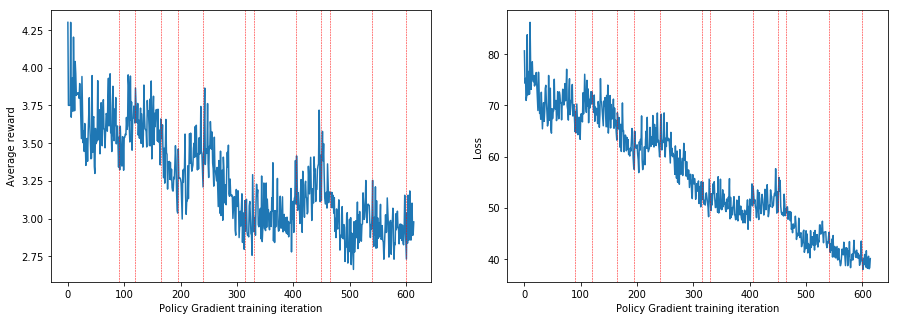

Junk: 23 out of 144, 	 junk_rate = 16.0%

Threshold: 0.31384
Found 33 molecules above threshold (22.92%).
Number of new molecules simce last training: 85
Saving checkpoint...
Iteration fininshed. Elapsed time: 241.332 sec.


------------------------------------------------------------
Iteration 41 of 100. Threshold = 0.314
------------------------------------------------------------


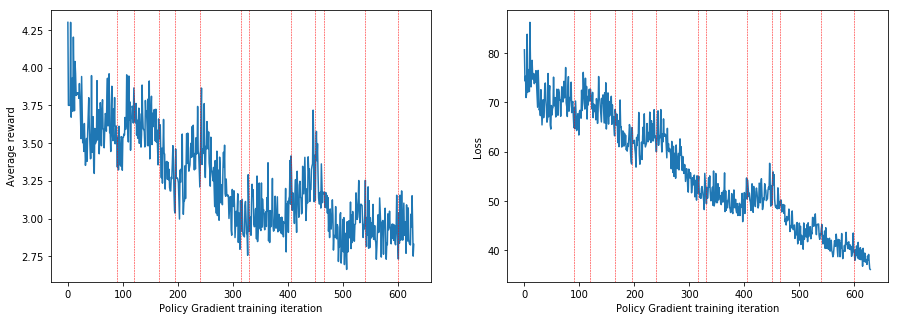

Junk: 20 out of 160, 	 junk_rate = 12.5%

Threshold: 0.31384
Found 28 molecules above threshold (17.50%).
Number of new molecules simce last training: 113


Iteration fininshed. Elapsed time: 292.962 sec.


------------------------------------------------------------
Iteration 42 of 100. Threshold = 0.314
------------------------------------------------------------


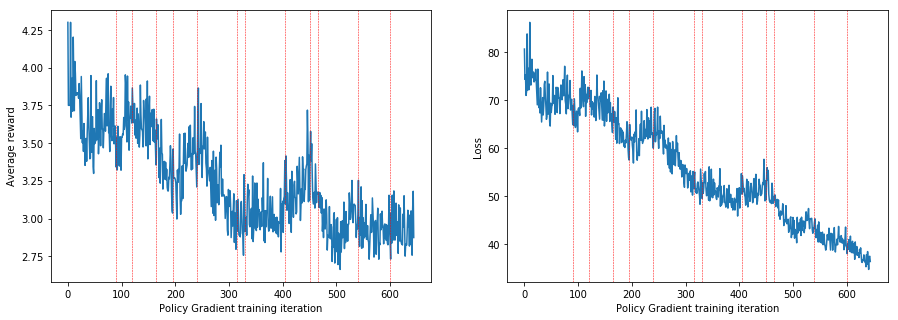

Junk: 22 out of 159, 	 junk_rate = 13.8%

Threshold: 0.31384
Found 42 molecules above threshold (26.42%).
Number of new molecules simce last training: 42
Iteration fininshed. Elapsed time: 244.806 sec.


------------------------------------------------------------
Iteration 43 of 100. Threshold = 0.314
------------------------------------------------------------


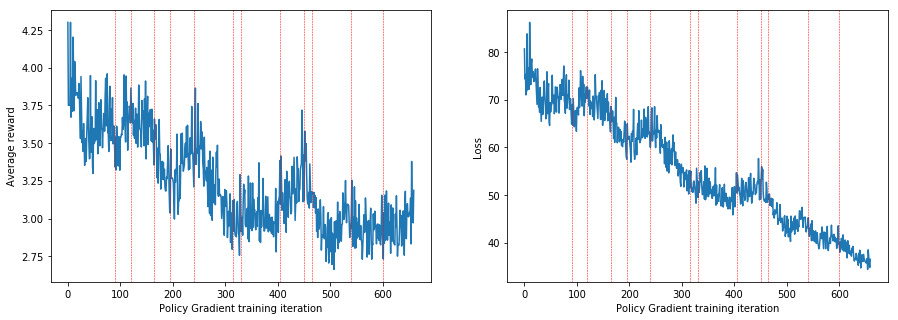

Junk: 20 out of 157, 	 junk_rate = 12.7%

Threshold: 0.31384
Found 47 molecules above threshold (29.94%).
Number of new molecules simce last training: 89
Iteration fininshed. Elapsed time: 246.658 sec.


------------------------------------------------------------
Iteration 44 of 100. Threshold = 0.314
------------------------------------------------------------


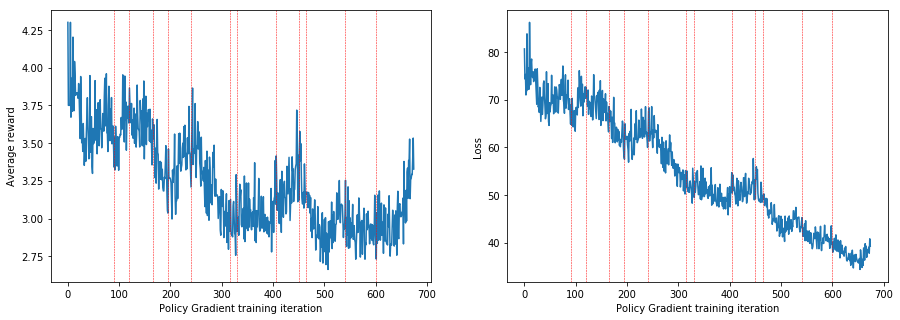

Junk: 27 out of 171, 	 junk_rate = 15.8%

Threshold: 0.31384
Found 57 molecules above threshold (33.33%).
Adjusting threshold to 0.34523 for next iteration.
Number of new molecules simce last training: 146


Iteration fininshed. Elapsed time: 296.401 sec.


------------------------------------------------------------
Iteration 45 of 100. Threshold = 0.345
------------------------------------------------------------


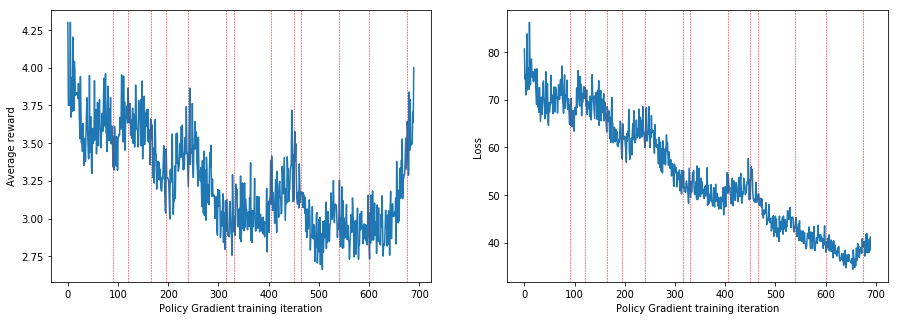

Junk: 20 out of 166, 	 junk_rate = 12.0%

Threshold: 0.34523
Found 49 molecules above threshold (29.52%).
Number of new molecules simce last training: 49
Iteration fininshed. Elapsed time: 245.144 sec.


------------------------------------------------------------
Iteration 46 of 100. Threshold = 0.345
------------------------------------------------------------


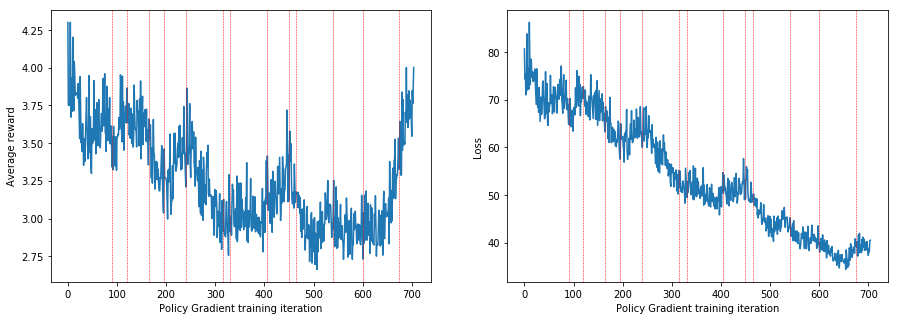

Junk: 20 out of 160, 	 junk_rate = 12.5%

Threshold: 0.34523
Found 45 molecules above threshold (28.12%).
Number of new molecules simce last training: 94
Iteration fininshed. Elapsed time: 246.443 sec.


------------------------------------------------------------
Iteration 47 of 100. Threshold = 0.345
------------------------------------------------------------


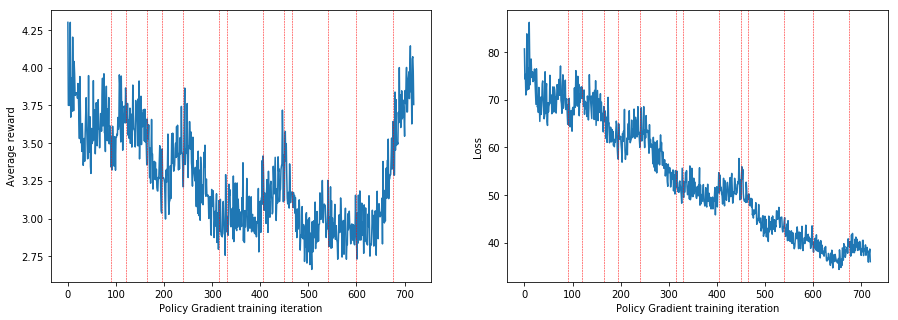

Junk: 21 out of 165, 	 junk_rate = 12.7%

Threshold: 0.34523
Found 60 molecules above threshold (36.36%).
Adjusting threshold to 0.37975 for next iteration.
Number of new molecules simce last training: 154


Iteration fininshed. Elapsed time: 284.323 sec.


------------------------------------------------------------
Iteration 48 of 100. Threshold = 0.380
------------------------------------------------------------


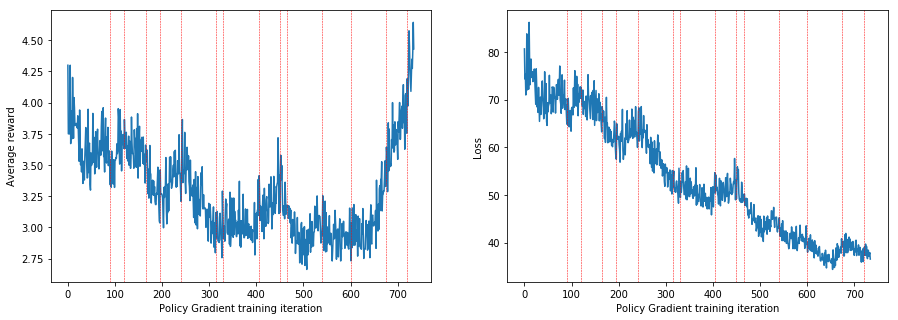

Junk: 16 out of 145, 	 junk_rate = 11.0%

Threshold: 0.37975
Found 53 molecules above threshold (36.55%).
Adjusting threshold to 0.41772 for next iteration.
Number of new molecules simce last training: 53
Iteration fininshed. Elapsed time: 228.338 sec.


------------------------------------------------------------
Iteration 49 of 100. Threshold = 0.418
------------------------------------------------------------


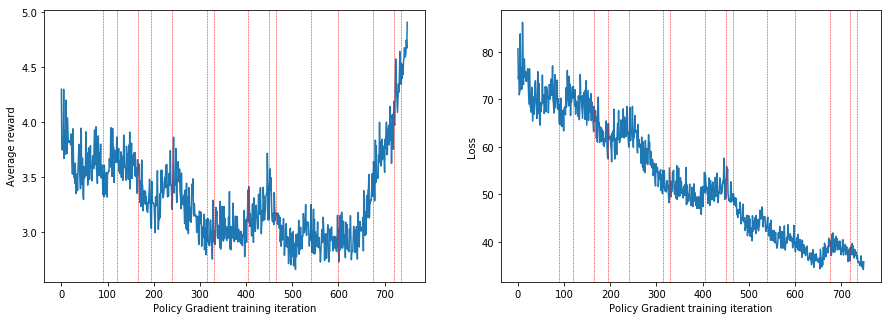

Junk: 17 out of 149, 	 junk_rate = 11.4%

Threshold: 0.41772
Found 52 molecules above threshold (34.90%).
Adjusting threshold to 0.4595 for next iteration.
Number of new molecules simce last training: 105


Iteration fininshed. Elapsed time: 266.774 sec.


------------------------------------------------------------
Iteration 50 of 100. Threshold = 0.459
------------------------------------------------------------


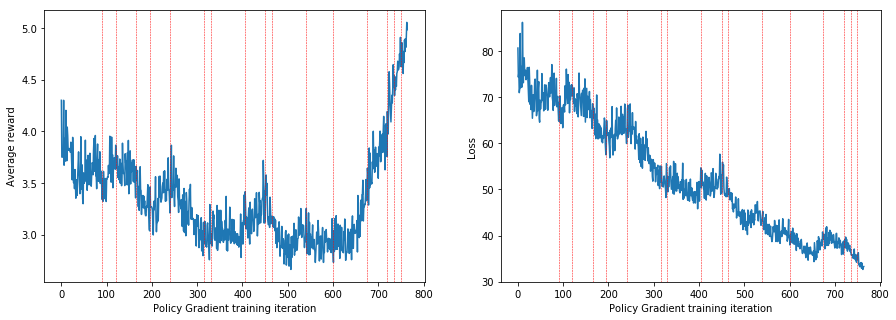

Junk: 12 out of 140, 	 junk_rate = 8.6%

Threshold: 0.4595
Found 48 molecules above threshold (34.29%).
Adjusting threshold to 0.5 for next iteration.
Number of new molecules simce last training: 48
Saving checkpoint...
Iteration fininshed. Elapsed time: 226.491 sec.


------------------------------------------------------------
Iteration 51 of 100. Threshold = 0.500
------------------------------------------------------------


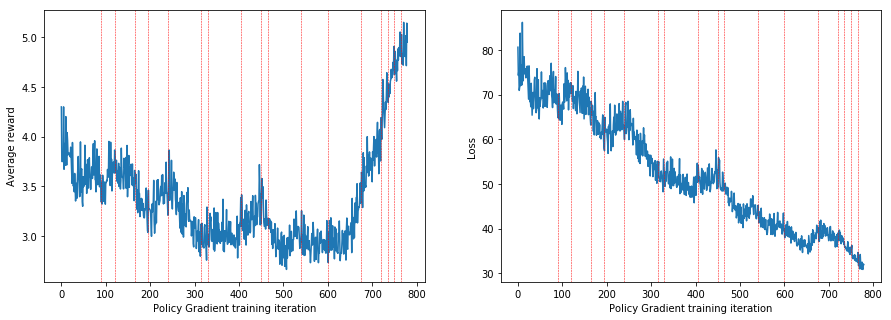

Junk: 13 out of 139, 	 junk_rate = 9.4%

Threshold: 0.5
Found 41 molecules above threshold (29.50%).
Number of new molecules simce last training: 89
Iteration fininshed. Elapsed time: 220.399 sec.


------------------------------------------------------------
Iteration 52 of 100. Threshold = 0.500
------------------------------------------------------------


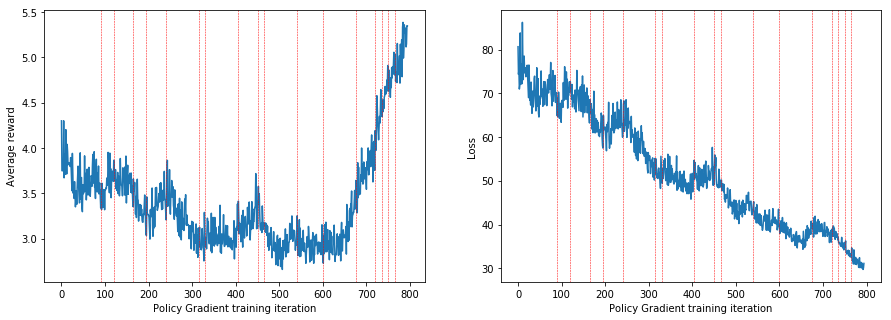

Junk: 10 out of 125, 	 junk_rate = 8.0%

Threshold: 0.5
Found 41 molecules above threshold (32.80%).
Adjusting threshold to 0.55 for next iteration.
Number of new molecules simce last training: 130


Iteration fininshed. Elapsed time: 249.892 sec.


------------------------------------------------------------
Iteration 53 of 100. Threshold = 0.550
------------------------------------------------------------


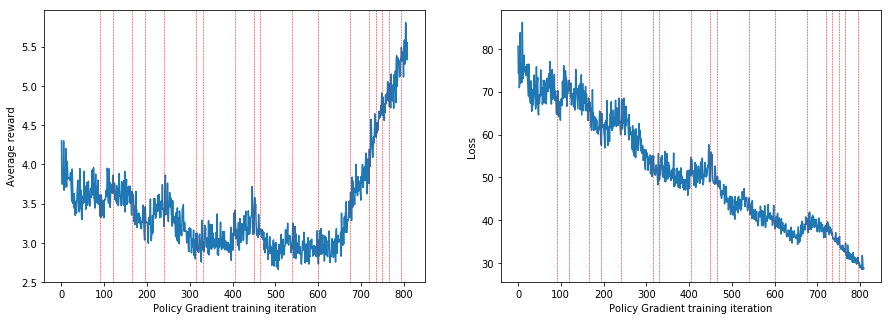

Junk: 9 out of 132, 	 junk_rate = 6.8%

Threshold: 0.55
Found 41 molecules above threshold (31.06%).
Adjusting threshold to 0.6 for next iteration.
Number of new molecules simce last training: 41
Iteration fininshed. Elapsed time: 219.674 sec.


------------------------------------------------------------
Iteration 54 of 100. Threshold = 0.600
------------------------------------------------------------


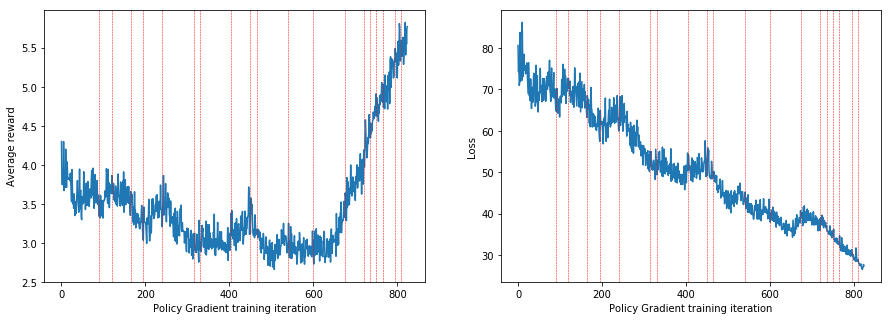

Junk: 9 out of 117, 	 junk_rate = 7.7%

Threshold: 0.6
Found 35 molecules above threshold (29.91%).
Number of new molecules simce last training: 76
Iteration fininshed. Elapsed time: 208.904 sec.


------------------------------------------------------------
Iteration 55 of 100. Threshold = 0.600
------------------------------------------------------------


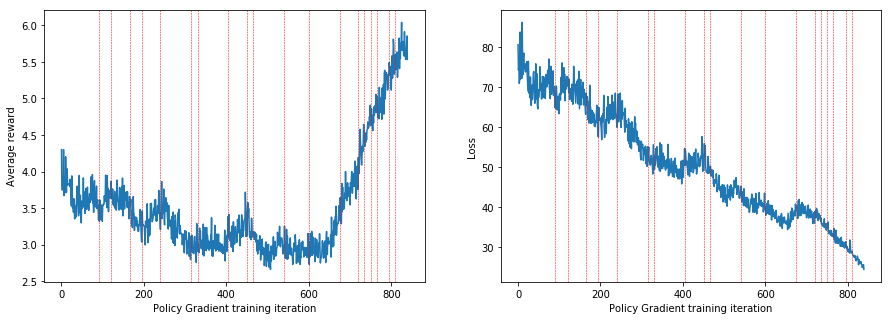

Junk: 11 out of 106, 	 junk_rate = 10.4%

Threshold: 0.6
Found 29 molecules above threshold (27.36%).
Number of new molecules simce last training: 105


Iteration fininshed. Elapsed time: 239.640 sec.


------------------------------------------------------------
Iteration 56 of 100. Threshold = 0.600
------------------------------------------------------------


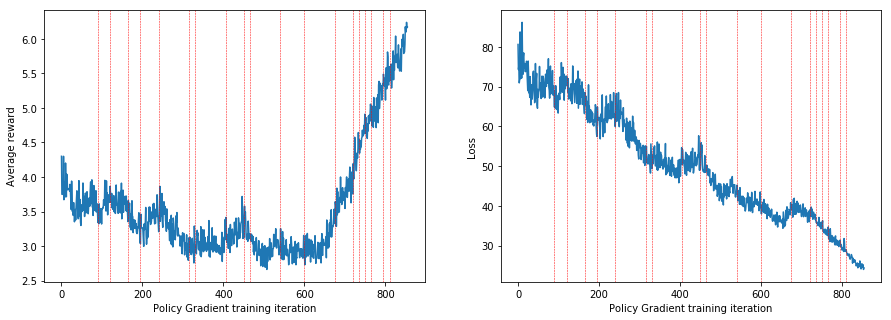

Junk: 7 out of 102, 	 junk_rate = 6.9%

Threshold: 0.6
Found 44 molecules above threshold (43.14%).
Adjusting threshold to 0.65 for next iteration.
Number of new molecules simce last training: 44
Iteration fininshed. Elapsed time: 205.081 sec.


------------------------------------------------------------
Iteration 57 of 100. Threshold = 0.650
------------------------------------------------------------


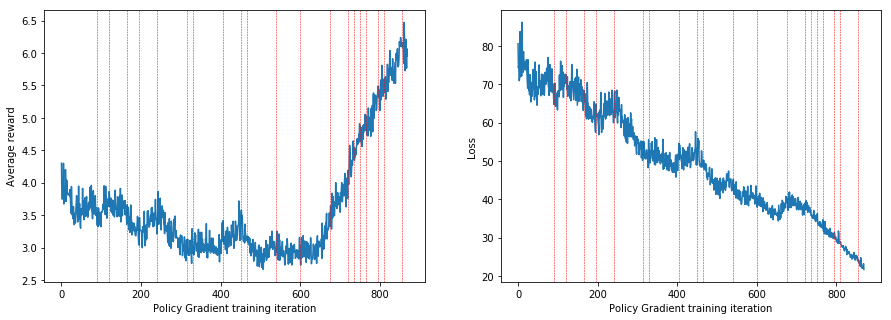

Junk: 9 out of 88, 	 junk_rate = 10.2%

Threshold: 0.65
Found 20 molecules above threshold (22.73%).
Number of new molecules simce last training: 64
Iteration fininshed. Elapsed time: 193.258 sec.


------------------------------------------------------------
Iteration 58 of 100. Threshold = 0.650
------------------------------------------------------------


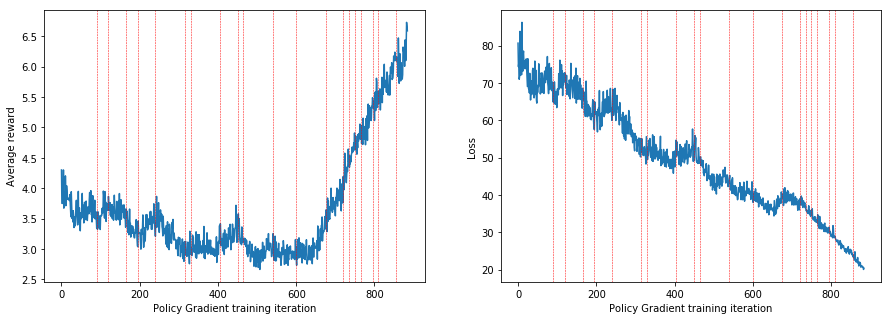

Junk: 4 out of 87, 	 junk_rate = 4.6%

Threshold: 0.65
Found 19 molecules above threshold (21.84%).
Number of new molecules simce last training: 83
Iteration fininshed. Elapsed time: 195.983 sec.


------------------------------------------------------------
Iteration 59 of 100. Threshold = 0.650
------------------------------------------------------------


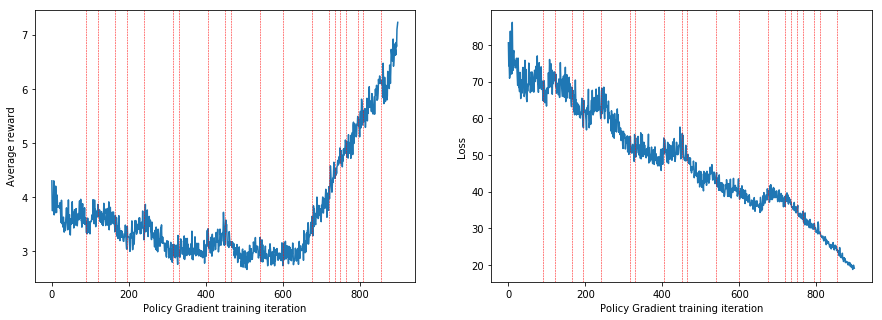

Junk: 4 out of 75, 	 junk_rate = 5.3%

Threshold: 0.65
Found 19 molecules above threshold (25.33%).
Number of new molecules simce last training: 102


Iteration fininshed. Elapsed time: 225.628 sec.


------------------------------------------------------------
Iteration 60 of 100. Threshold = 0.650
------------------------------------------------------------


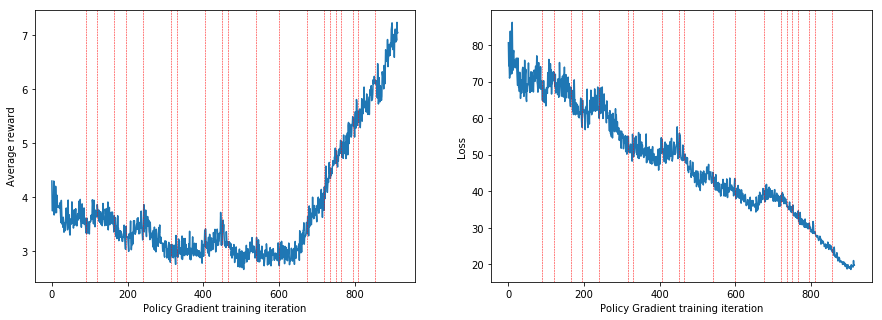

Junk: 6 out of 78, 	 junk_rate = 7.7%

Threshold: 0.65
Found 23 molecules above threshold (29.49%).
Number of new molecules simce last training: 23
Saving checkpoint...
Iteration fininshed. Elapsed time: 191.061 sec.


------------------------------------------------------------
Iteration 61 of 100. Threshold = 0.650
------------------------------------------------------------


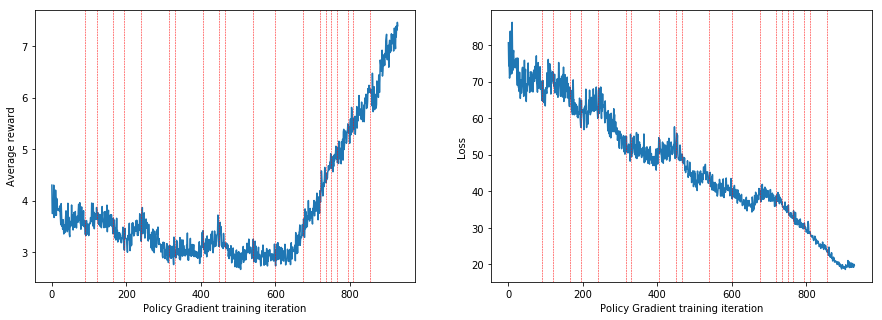

Junk: 8 out of 75, 	 junk_rate = 10.7%

Threshold: 0.65
Found 16 molecules above threshold (21.33%).
Number of new molecules simce last training: 39
Iteration fininshed. Elapsed time: 189.843 sec.


------------------------------------------------------------
Iteration 62 of 100. Threshold = 0.650
------------------------------------------------------------


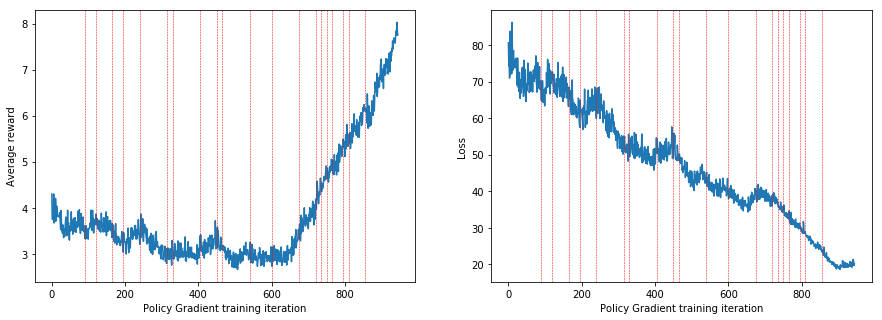

Junk: 10 out of 57, 	 junk_rate = 17.5%

Threshold: 0.65
Found 21 molecules above threshold (36.84%).
Adjusting threshold to 0.7 for next iteration.
Number of new molecules simce last training: 60
Iteration fininshed. Elapsed time: 178.540 sec.


------------------------------------------------------------
Iteration 63 of 100. Threshold = 0.700
------------------------------------------------------------


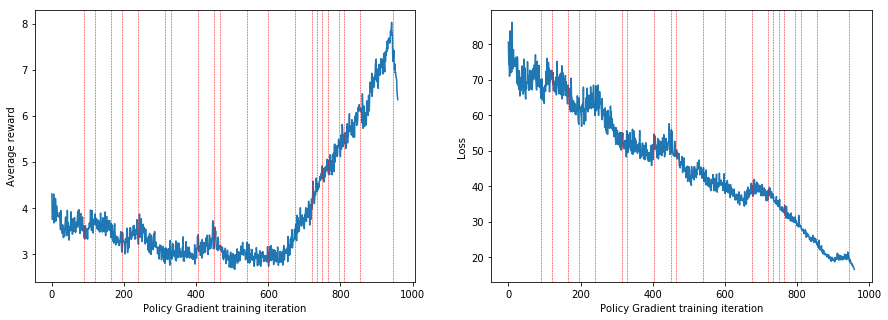

Junk: 5 out of 70, 	 junk_rate = 7.1%

Threshold: 0.7
Found 6 molecules above threshold (8.57%).
Number of new molecules simce last training: 66
Iteration fininshed. Elapsed time: 188.434 sec.


------------------------------------------------------------
Iteration 64 of 100. Threshold = 0.700
------------------------------------------------------------


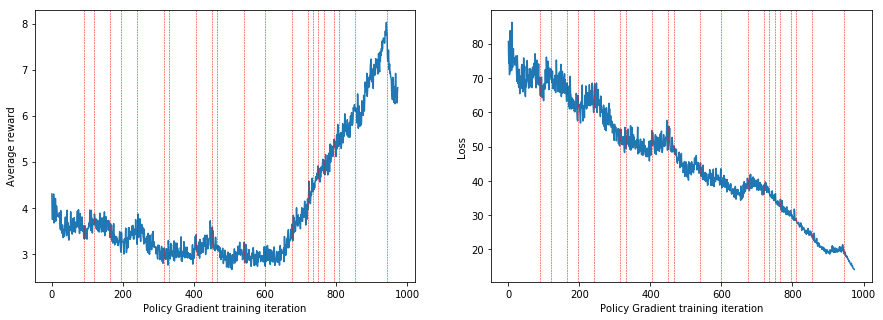

Junk: 11 out of 54, 	 junk_rate = 20.4%

Threshold: 0.7
Found 3 molecules above threshold (5.56%).
Number of new molecules simce last training: 69
Iteration fininshed. Elapsed time: 173.312 sec.


------------------------------------------------------------
Iteration 65 of 100. Threshold = 0.700
------------------------------------------------------------


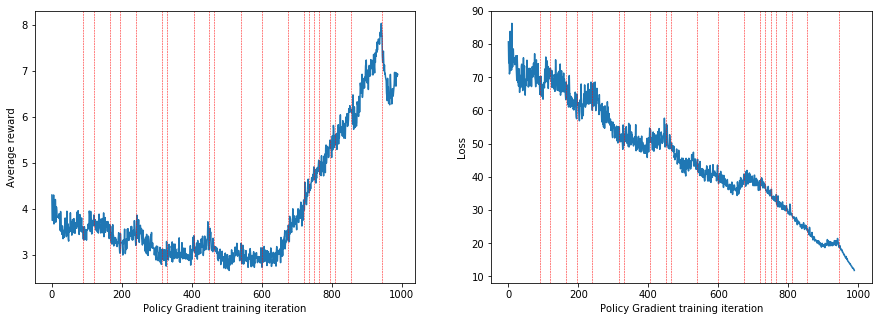

Junk: 6 out of 37, 	 junk_rate = 16.2%

Threshold: 0.7
Found 3 molecules above threshold (8.11%).
Number of new molecules simce last training: 72
Iteration fininshed. Elapsed time: 165.523 sec.


------------------------------------------------------------
Iteration 66 of 100. Threshold = 0.700
------------------------------------------------------------


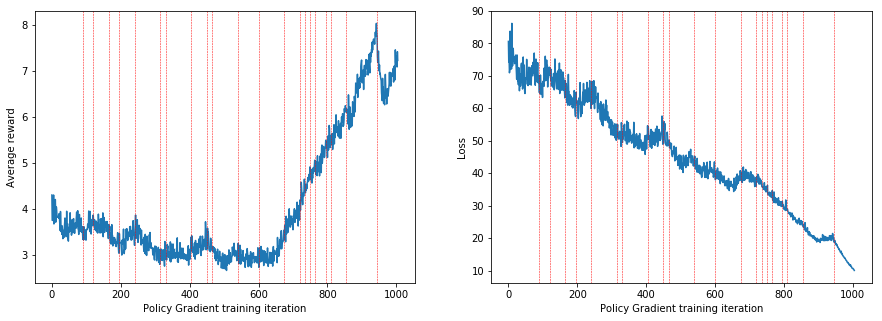

Junk: 4 out of 55, 	 junk_rate = 7.3%

Threshold: 0.7
Found 2 molecules above threshold (3.64%).
Number of new molecules simce last training: 74
Iteration fininshed. Elapsed time: 173.222 sec.


------------------------------------------------------------
Iteration 67 of 100. Threshold = 0.700
------------------------------------------------------------


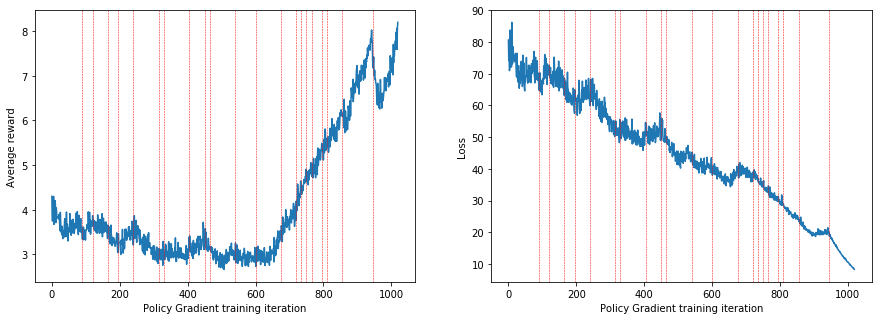

Junk: 4 out of 35, 	 junk_rate = 11.4%

Threshold: 0.7
Found 3 molecules above threshold (8.57%).
Number of new molecules simce last training: 77
Iteration fininshed. Elapsed time: 165.902 sec.


------------------------------------------------------------
Iteration 68 of 100. Threshold = 0.700
------------------------------------------------------------


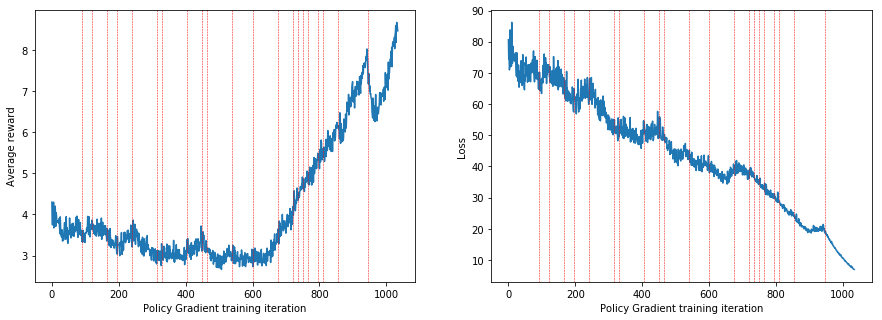

Junk: 7 out of 28, 	 junk_rate = 25.0%

Threshold: 0.7
Found 2 molecules above threshold (7.14%).
Number of new molecules simce last training: 79
Iteration fininshed. Elapsed time: 160.462 sec.


------------------------------------------------------------
Iteration 69 of 100. Threshold = 0.700
------------------------------------------------------------


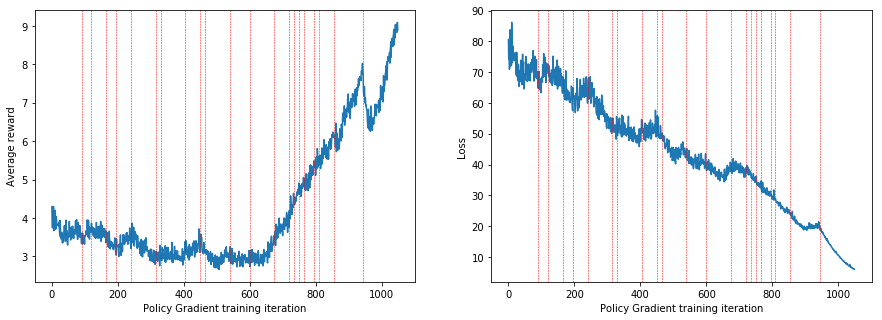

Junk: 2 out of 19, 	 junk_rate = 10.5%

Threshold: 0.7
Found 1 molecules above threshold (5.26%).
Number of new molecules simce last training: 80
Iteration fininshed. Elapsed time: 157.369 sec.


------------------------------------------------------------
Iteration 70 of 100. Threshold = 0.700
------------------------------------------------------------


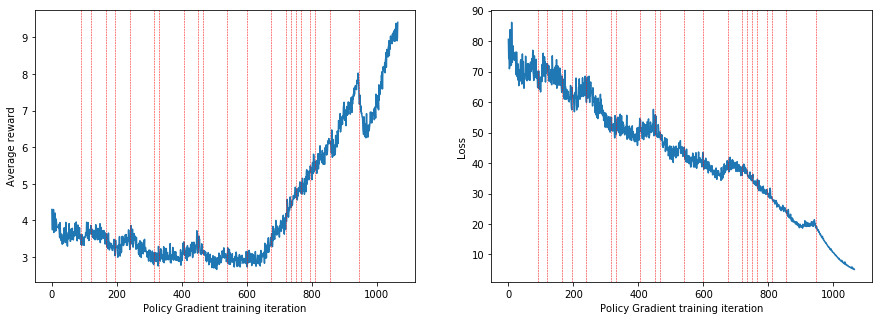

Junk: 1 out of 26, 	 junk_rate = 3.8%

Threshold: 0.7
Found 2 molecules above threshold (7.69%).
Number of new molecules simce last training: 82
Saving checkpoint...
Iteration fininshed. Elapsed time: 162.817 sec.


------------------------------------------------------------
Iteration 71 of 100. Threshold = 0.700
------------------------------------------------------------


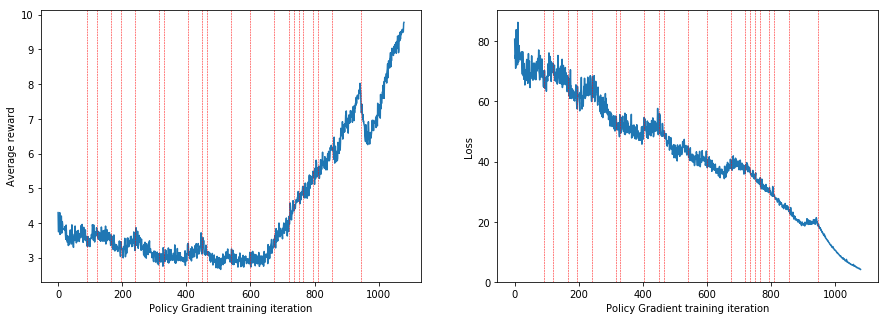

Junk: 1 out of 17, 	 junk_rate = 5.9%

Threshold: 0.7
Found 3 molecules above threshold (17.65%).
Number of new molecules simce last training: 85
Iteration fininshed. Elapsed time: 157.782 sec.


------------------------------------------------------------
Iteration 72 of 100. Threshold = 0.700
------------------------------------------------------------


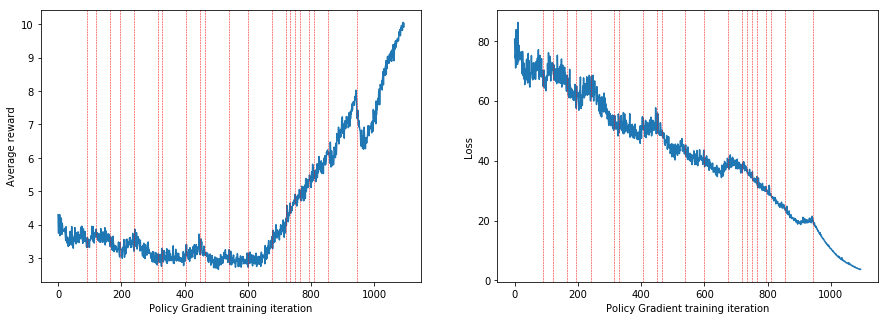

Junk: 3 out of 22, 	 junk_rate = 13.6%

Threshold: 0.7
Found 1 molecules above threshold (4.55%).
Number of new molecules simce last training: 86
Iteration fininshed. Elapsed time: 161.840 sec.


------------------------------------------------------------
Iteration 73 of 100. Threshold = 0.700
------------------------------------------------------------


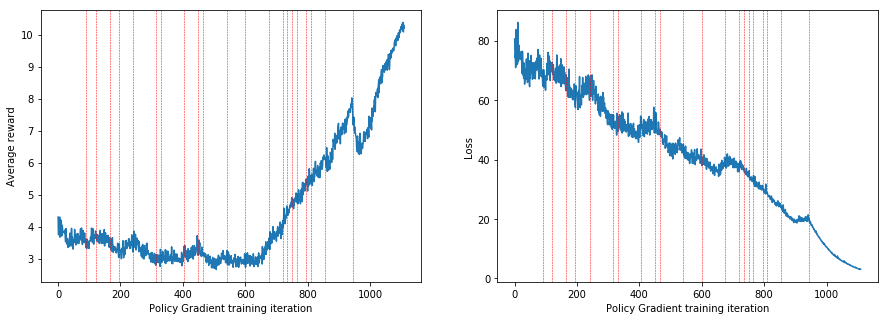

Junk: 1 out of 13, 	 junk_rate = 7.7%

Threshold: 0.7
Found 2 molecules above threshold (15.38%).
Number of new molecules simce last training: 88
Iteration fininshed. Elapsed time: 157.515 sec.


------------------------------------------------------------
Iteration 74 of 100. Threshold = 0.700
------------------------------------------------------------


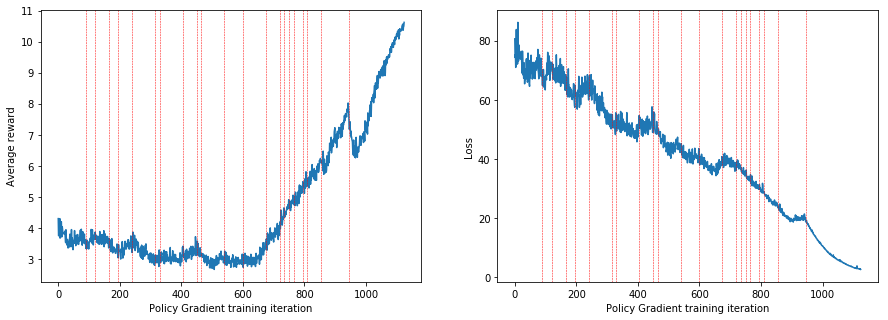

Junk: 0 out of 11, 	 junk_rate = 0.0%

Threshold: 0.7
Found 1 molecules above threshold (9.09%).
Number of new molecules simce last training: 89
Iteration fininshed. Elapsed time: 156.387 sec.


------------------------------------------------------------
Iteration 75 of 100. Threshold = 0.700
------------------------------------------------------------


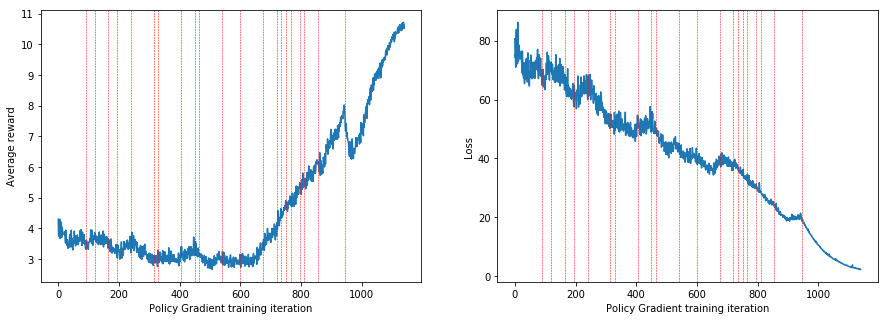

Junk: 2 out of 14, 	 junk_rate = 14.3%

Threshold: 0.7
Found 1 molecules above threshold (7.14%).
Number of new molecules simce last training: 90
Iteration fininshed. Elapsed time: 179.483 sec.


------------------------------------------------------------
Iteration 76 of 100. Threshold = 0.700
------------------------------------------------------------


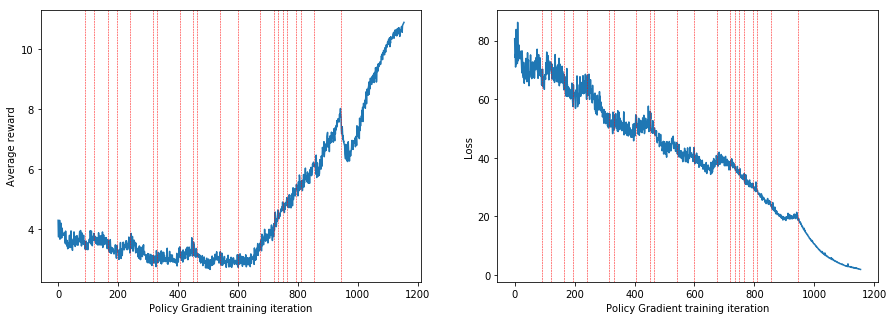

Junk: 1 out of 11, 	 junk_rate = 9.1%

Threshold: 0.7
Found 1 molecules above threshold (9.09%).
Number of new molecules simce last training: 91
Iteration fininshed. Elapsed time: 161.177 sec.


------------------------------------------------------------
Iteration 77 of 100. Threshold = 0.700
------------------------------------------------------------


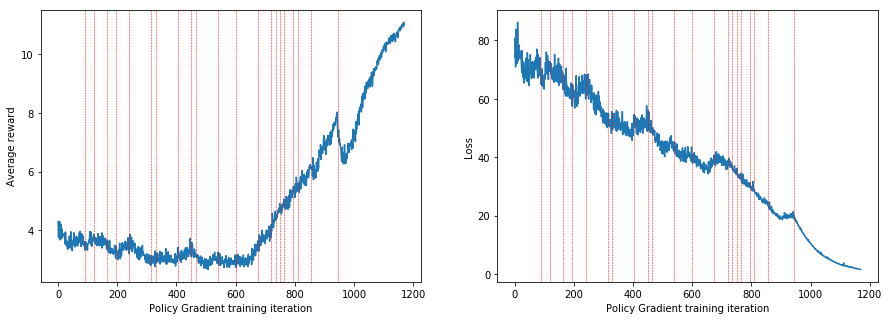

Junk: 2 out of 10, 	 junk_rate = 20.0%

Threshold: 0.7
Found 1 molecules above threshold (10.00%).
Number of new molecules simce last training: 92
Iteration fininshed. Elapsed time: 156.810 sec.


------------------------------------------------------------
Iteration 78 of 100. Threshold = 0.700
------------------------------------------------------------


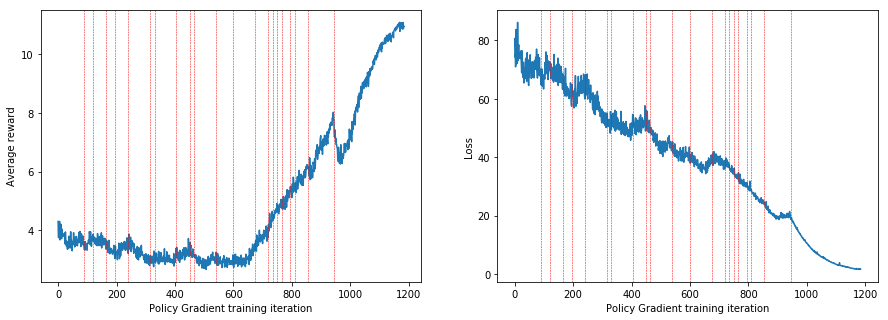

Junk: 1 out of 10, 	 junk_rate = 10.0%

Threshold: 0.7
Found 1 molecules above threshold (10.00%).
Number of new molecules simce last training: 93
Iteration fininshed. Elapsed time: 157.219 sec.


------------------------------------------------------------
Iteration 79 of 100. Threshold = 0.700
------------------------------------------------------------


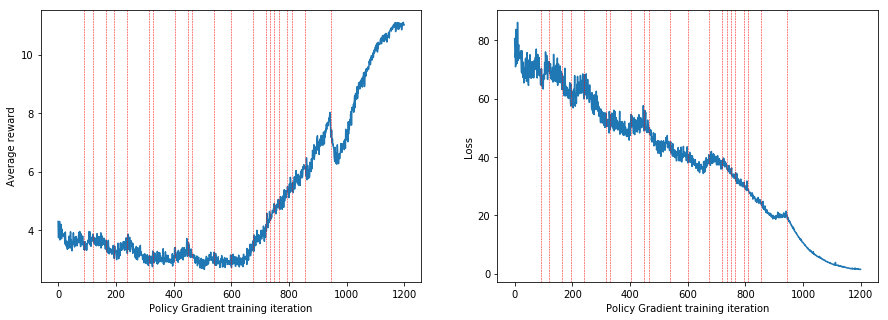

Junk: 3 out of 9, 	 junk_rate = 33.3%

Threshold: 0.7
Found 1 molecules above threshold (11.11%).
Number of new molecules simce last training: 94
Iteration fininshed. Elapsed time: 155.479 sec.


------------------------------------------------------------
Iteration 80 of 100. Threshold = 0.700
------------------------------------------------------------


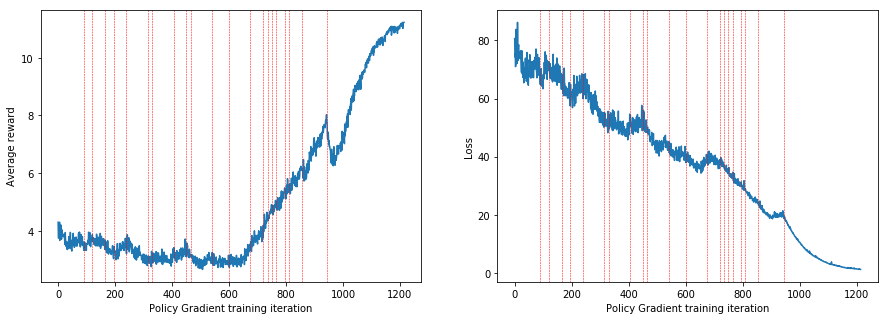

Junk: 0 out of 7, 	 junk_rate = 0.0%

Threshold: 0.7
Found 1 molecules above threshold (14.29%).
Number of new molecules simce last training: 95
Saving checkpoint...
Iteration fininshed. Elapsed time: 155.277 sec.


------------------------------------------------------------
Iteration 81 of 100. Threshold = 0.700
------------------------------------------------------------


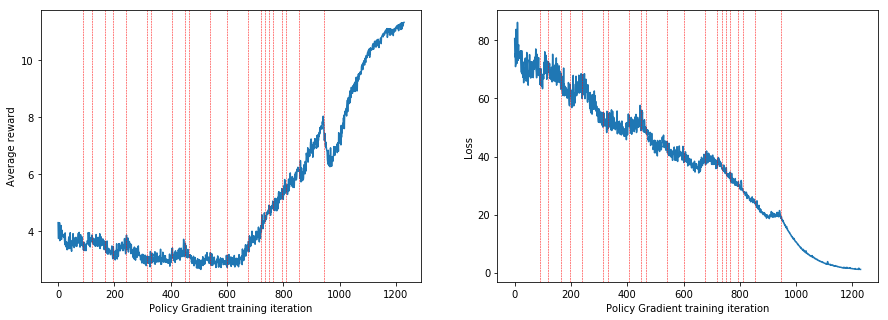

Junk: 2 out of 13, 	 junk_rate = 15.4%

Threshold: 0.7
Found 1 molecules above threshold (7.69%).
Number of new molecules simce last training: 96
Iteration fininshed. Elapsed time: 157.390 sec.


------------------------------------------------------------
Iteration 82 of 100. Threshold = 0.700
------------------------------------------------------------


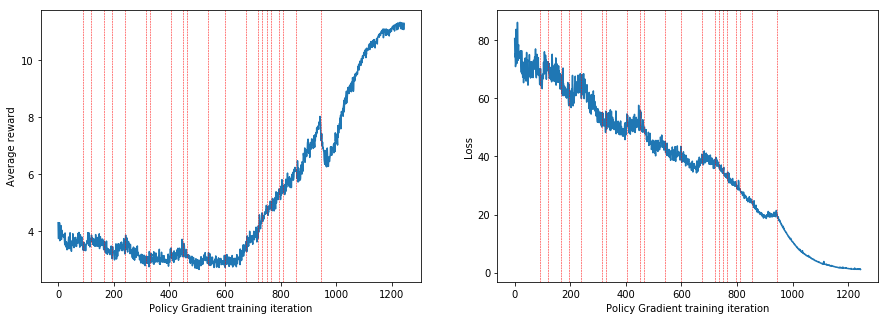

Junk: 1 out of 8, 	 junk_rate = 12.5%

Threshold: 0.7
Found 2 molecules above threshold (25.00%).
Number of new molecules simce last training: 98
Iteration fininshed. Elapsed time: 153.524 sec.


------------------------------------------------------------
Iteration 83 of 100. Threshold = 0.700
------------------------------------------------------------


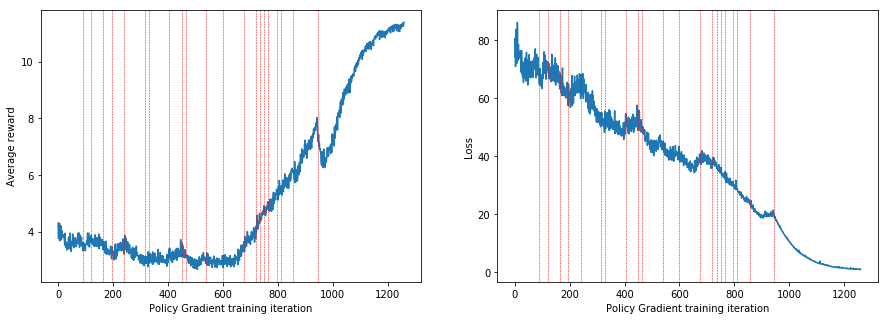

Junk: 2 out of 5, 	 junk_rate = 40.0%

Threshold: 0.7
Found 1 molecules above threshold (20.00%).
Number of new molecules simce last training: 99
Iteration fininshed. Elapsed time: 152.416 sec.


------------------------------------------------------------
Iteration 84 of 100. Threshold = 0.700
------------------------------------------------------------


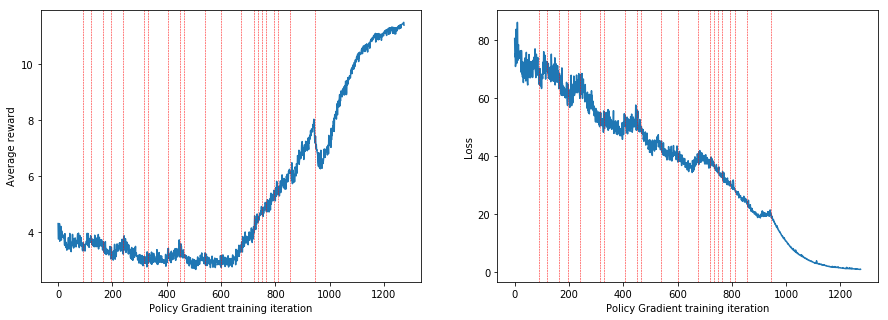

Junk: 0 out of 5, 	 junk_rate = 0.0%

Threshold: 0.7
Found 1 molecules above threshold (20.00%).
Number of new molecules simce last training: 100
Iteration fininshed. Elapsed time: 152.799 sec.


------------------------------------------------------------
Iteration 85 of 100. Threshold = 0.700
------------------------------------------------------------


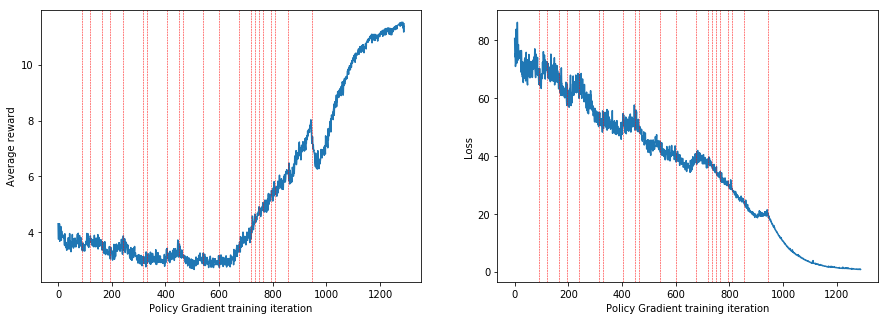

Junk: 0 out of 7, 	 junk_rate = 0.0%

Threshold: 0.7
Found 1 molecules above threshold (14.29%).
Number of new molecules simce last training: 101


Iteration fininshed. Elapsed time: 186.257 sec.


------------------------------------------------------------
Iteration 86 of 100. Threshold = 0.700
------------------------------------------------------------


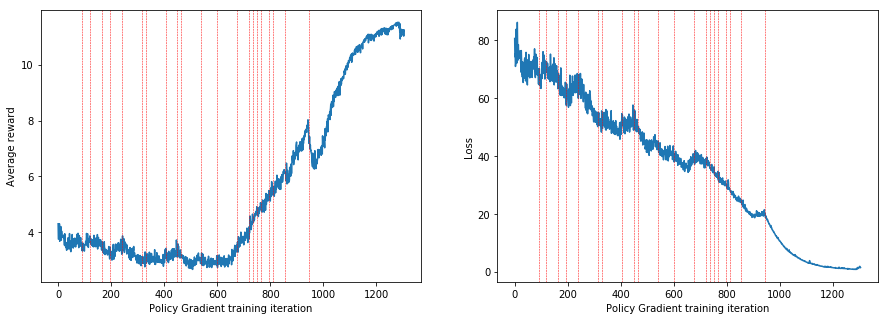

Junk: 1 out of 19, 	 junk_rate = 5.3%

Threshold: 0.7
Found 2 molecules above threshold (10.53%).
Number of new molecules simce last training: 2
Iteration fininshed. Elapsed time: 160.916 sec.


------------------------------------------------------------
Iteration 87 of 100. Threshold = 0.700
------------------------------------------------------------


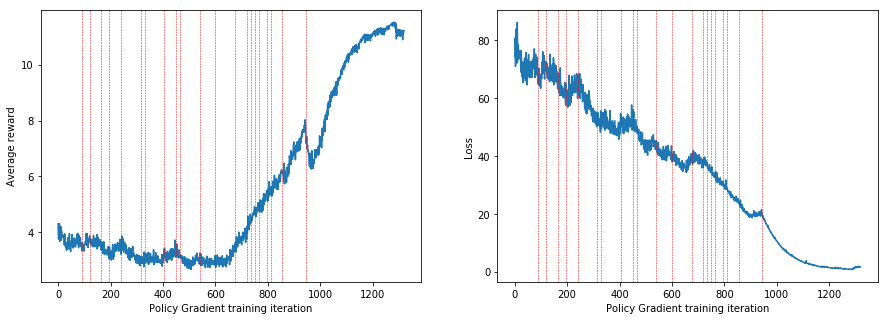

Junk: 1 out of 16, 	 junk_rate = 6.2%

Threshold: 0.7
Found 2 molecules above threshold (12.50%).
Number of new molecules simce last training: 4
Iteration fininshed. Elapsed time: 159.468 sec.


------------------------------------------------------------
Iteration 88 of 100. Threshold = 0.700
------------------------------------------------------------


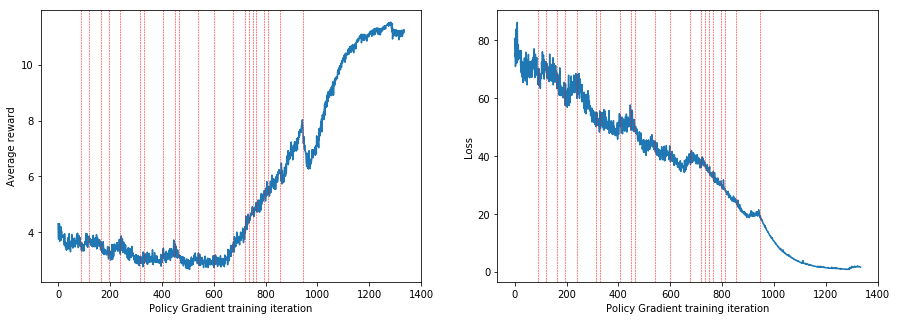

Junk: 0 out of 11, 	 junk_rate = 0.0%

Threshold: 0.7
Found 3 molecules above threshold (27.27%).
Number of new molecules simce last training: 7
Iteration fininshed. Elapsed time: 156.608 sec.


------------------------------------------------------------
Iteration 89 of 100. Threshold = 0.700
------------------------------------------------------------


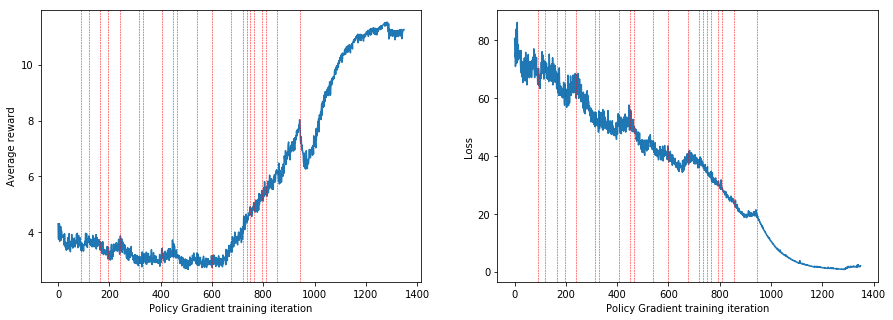

Junk: 0 out of 9, 	 junk_rate = 0.0%

Threshold: 0.7
Found 2 molecules above threshold (22.22%).
Number of new molecules simce last training: 9
Iteration fininshed. Elapsed time: 156.095 sec.


------------------------------------------------------------
Iteration 90 of 100. Threshold = 0.700
------------------------------------------------------------


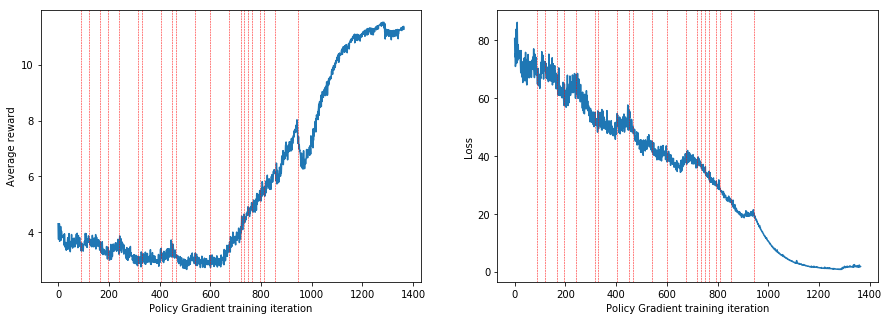

Junk: 0 out of 10, 	 junk_rate = 0.0%

Threshold: 0.7
Found 2 molecules above threshold (20.00%).
Number of new molecules simce last training: 11
Saving checkpoint...
Iteration fininshed. Elapsed time: 156.966 sec.


------------------------------------------------------------
Iteration 91 of 100. Threshold = 0.700
------------------------------------------------------------


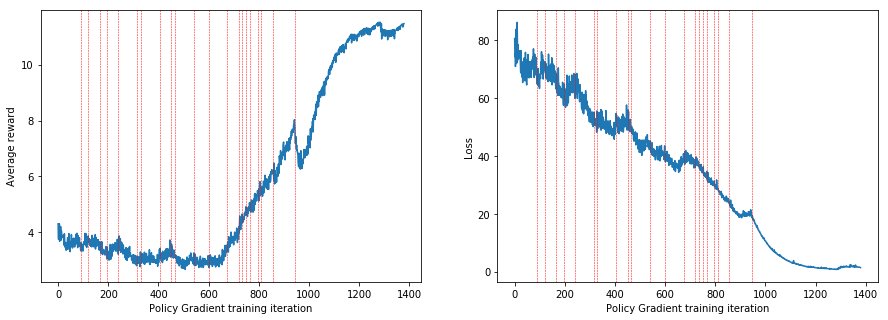

Junk: 0 out of 8, 	 junk_rate = 0.0%

Threshold: 0.7
Found 3 molecules above threshold (37.50%).
Adjusting threshold to 0.75 for next iteration.
Number of new molecules simce last training: 14
Iteration fininshed. Elapsed time: 155.255 sec.


------------------------------------------------------------
Iteration 92 of 100. Threshold = 0.750
------------------------------------------------------------


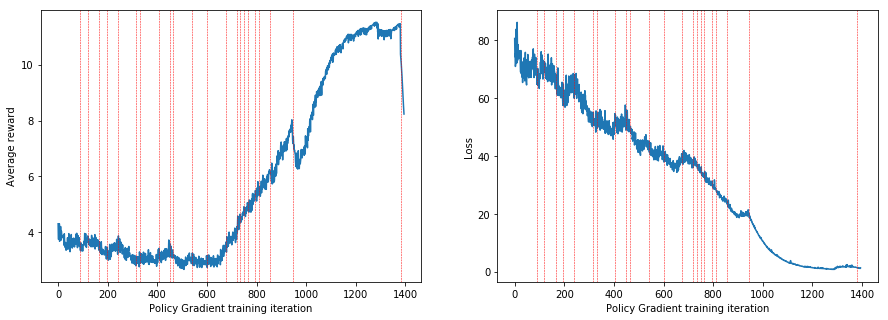

Junk: 1 out of 7, 	 junk_rate = 14.3%

Threshold: 0.75
Iteration fininshed. Elapsed time: 153.230 sec.


------------------------------------------------------------
Iteration 93 of 100. Threshold = 0.750
------------------------------------------------------------


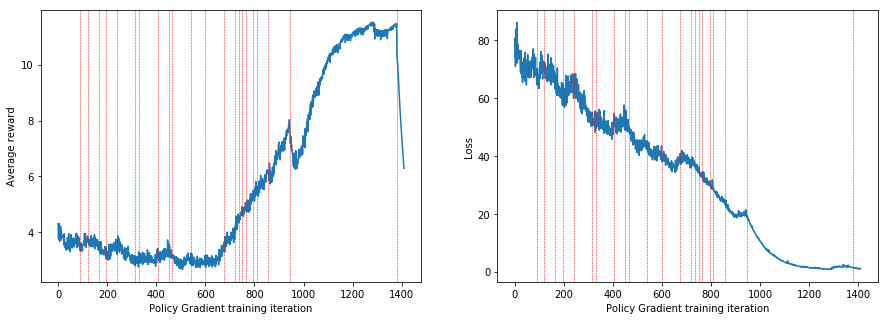

Junk: 1 out of 7, 	 junk_rate = 14.3%

Threshold: 0.75
Iteration fininshed. Elapsed time: 154.323 sec.


------------------------------------------------------------
Iteration 94 of 100. Threshold = 0.750
------------------------------------------------------------


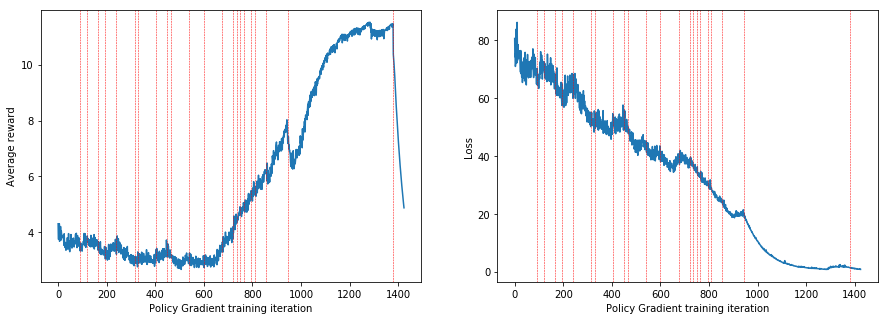

Junk: 0 out of 3, 	 junk_rate = 0.0%

Threshold: 0.75
Iteration fininshed. Elapsed time: 151.566 sec.


------------------------------------------------------------
Iteration 95 of 100. Threshold = 0.750
------------------------------------------------------------


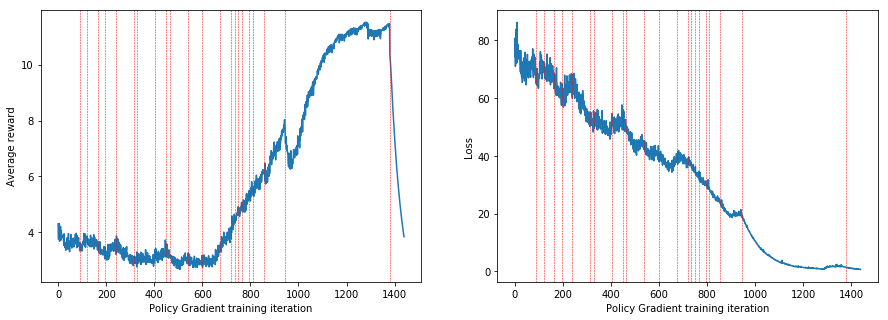

Junk: 0 out of 7, 	 junk_rate = 0.0%

Threshold: 0.75
Iteration fininshed. Elapsed time: 154.639 sec.


------------------------------------------------------------
Iteration 96 of 100. Threshold = 0.750
------------------------------------------------------------


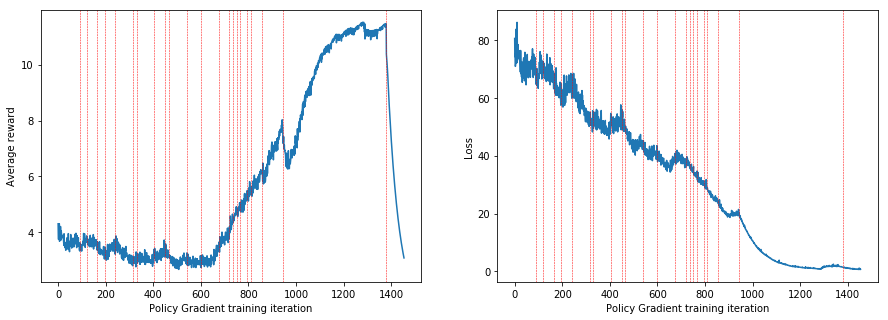

Junk: 2 out of 10, 	 junk_rate = 20.0%

Threshold: 0.75
Iteration fininshed. Elapsed time: 155.155 sec.


------------------------------------------------------------
Iteration 97 of 100. Threshold = 0.750
------------------------------------------------------------


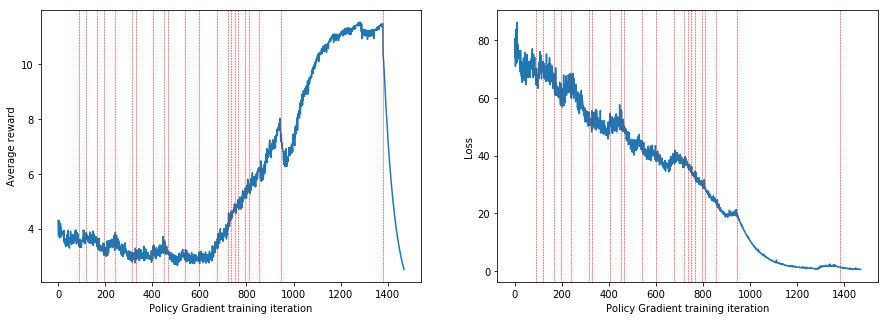

Junk: 2 out of 9, 	 junk_rate = 22.2%

Threshold: 0.75
Iteration fininshed. Elapsed time: 153.691 sec.


------------------------------------------------------------
Iteration 98 of 100. Threshold = 0.750
------------------------------------------------------------


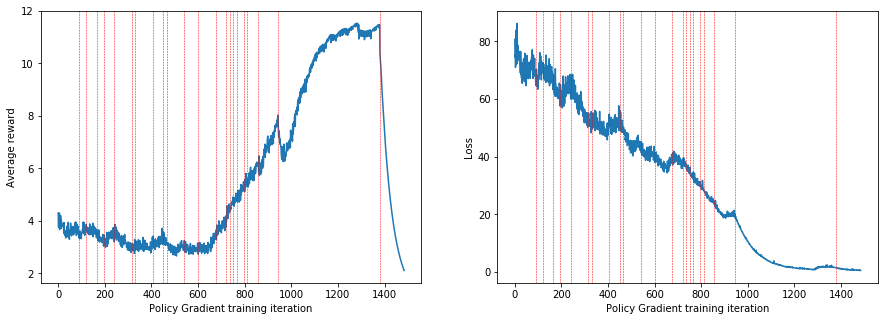

Junk: 0 out of 9, 	 junk_rate = 0.0%

Threshold: 0.75
Iteration fininshed. Elapsed time: 156.174 sec.


------------------------------------------------------------
Iteration 99 of 100. Threshold = 0.750
------------------------------------------------------------


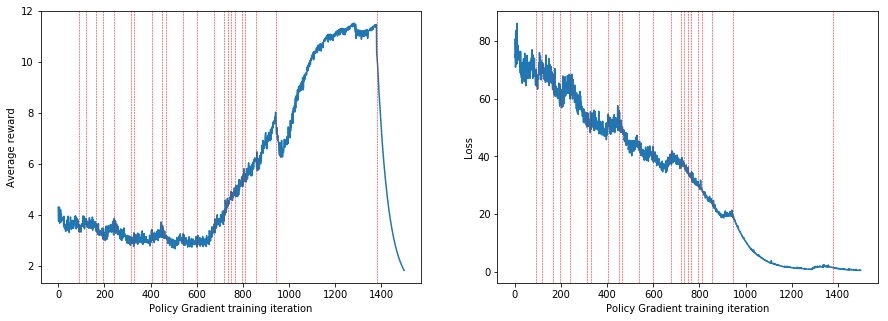

Junk: 0 out of 9, 	 junk_rate = 0.0%

Threshold: 0.75
Iteration fininshed. Elapsed time: 156.644 sec.
Wall time: 5h 51min 41s


In [46]:
%%time
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 100

# Setting up some parameters for the experiment
# n_to_generate = 20
# n_policy_replay = 3
# n_policy = 5
# n_iterations = 3

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    for i in tqdm(range(n_iterations), desc='Iteration:'):
        threshold = rw_args["threshold"]
        print("\n")
        print("-"*60)
        print(f"Iteration {i} of {n_iterations}. Threshold = {threshold:.3f}")
        print("-"*60)
        
        start_time = time.time()
        for j in tqdm(range(n_policy), desc='Policy gradient...'):
            
            cur_reward, cur_loss = RL_activity.policy_gradient(gen_data, **rw_args)
            rewards.append(simple_moving_average(rewards, cur_reward)) 
            rl_losses.append(simple_moving_average(rl_losses, cur_loss))

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        ax[0].plot(rewards)
        ax[0].set_xlabel('Policy Gradient training iteration')
        ax[0].set_ylabel('Average reward')
        #plt.show()
        ax[1].plot(rl_losses)
        ax[1].set_xlabel('Policy Gradient training iteration')
        ax[1].set_ylabel('Loss')
        
        for ch in thr_changes:
            ax[0].axvline(x=ch, linewidth=0.5, ls='dashed', c='red')
            ax[1].axvline(x=ch, linewidth=0.5, ls='dashed', c='red')
            
        plt.show()

        smiles_cur, prediction_cur = estimate_and_update(RL_activity.generator, 
                                                         my_predictor, n_to_generate)
        
        #for s, ss in enumerate(smiles_cur):
        #    print(smiles_cur[s], prediction_cur[s])
        
        
        # Supervised training
        # -------------------
        # At every iteration, we use the best results to retrain the generator
        # biasing it to generate more active molecules
            
        # Select mols with pred_proba > threshold
        threshold = rw_args["threshold"]
        
        pred = np.array(prediction_cur)
        pred_above_thr = pred[ pred >= threshold ]
        above_thr = np.sum(np.array(prediction_cur) > threshold)/len(prediction_cur)
        
        # Keep a history of changes
        history_thresh.append(above_thr)
        history_newmol.append(len(pred))
        history_above.append(above_thr)
        history_smiles.append(smiles_cur)
        history_pred.append(prediction_cur)
        history_junk.append(sum(pred == -1) / len(pred))
        
        junk_rate.append(sum(pred == -1) / len(pred))
        print(f"Junk: {sum(pred == -1)} out of {len(pred)}, \t junk_rate = {junk_rate[-1:][0]:.1%}")
        print(f"\nThreshold: {threshold:.5}")

        if len(pred_above_thr) > 0:
            
            print(f"Found {len(pred_above_thr)} molecules above threshold ({above_thr:.2%})." )
        
            # There are new molecules with good predictions
            # add mols to gen_data.file
            _smi = np.array(smiles_cur)
            [gen_data.file.append('<'+s+'>') for s in _smi[pred >= threshold]]
            
            # If enough predictions are above the threshold, 
            # adjust threshold for the next round
            if above_thr >= 0.3 and threshold < thresh_limit:
                new_thr = threshold + min(threshold*.1, 0.05)
                if (0.5 < new_thr < 0.55):
                    new_thr = 0.5 
                rw_args["threshold"] = new_thr
                print(f"Adjusting threshold to {rw_args['threshold']:.5} for next iteration.")
                thr_changes.append(len(rewards))

            
            # When enough new molecules have been generated, retrain the generator on the best ones
            new_mols_since_last_train = len(gen_data.file) - gen_data.file_len
            print(f"Number of new molecules simce last training: {new_mols_since_last_train}")
            if (new_mols_since_last_train) > n_best:
                
                # Hold only the last n_best estimates. 
                # These should be improving as the threshold increases
                gen_data.file = gen_data.file[-n_best:]
                gen_data.file_len = len(gen_data.file)

                # Now, retrain the generator 
                losses = RL_activity.generator.fit(gen_data, 100)
        
        # Save a checkpoint file
        if (i % 10) == 0:
            chk_path = f"./chk/RL_activity_generator_{i:03}.chk"
            print("Saving checkpoint...")
            RL_activity.generator.save_model(chk_path)
        elapsed_time = time.time() - start_time
        print(f"Iteration fininshed. Elapsed time: {elapsed_time:0.3f} sec.")
        #print("Iteration fininshed. Elapsed time: ", time.strftime("%M:%S", time.gmtime(elapsed_time)))
        #----------------------------
        #print("\n\n\n")
        #print("-"*50)
        #print('Sample trajectories:')
        #for sm in smiles_cur[:5]:
        #    print(sm)
                      
                      
                      
                      

In [54]:
chk_path = "./chk/RL_activity_generator_100.chk"
print("Reading checkpoint...")
RL_activity.generator.save_model(chk_path)

Saving checkpoint...


## Comparing the biased and unbiased results

In [27]:
# If needed, load the biased generator here.
rl_model_path = './chk/RL_activity_generator_100.chk'
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)
my_generator_max.load_model(rl_model_path)

Now that the generator has been properly trained with RL to generate valid molecules with probability of being active, we can generate some molecules:

 <span style="color:red">
 **Warnings**
 
 I'm getting those warnings from data.py:
 ```
 ./release\data.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
return torch.tensor(tensor).cuda()
```

In the final version, correct this! For now, let's just catch the warnings.
</span>

In [41]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    smiles_biased, predicion_biased = estimate_and_update(my_generator_max, 
                                                           my_predictor,
                                                           n_to_generate=10000)


Valid SMILES : 9948 (99.48% of the total)
Unique SMILES: 216 (2.16% of the total)


In [40]:
smiles_biased, predicion_biased

(['COc1ccccc1C=C1C(=O)c2ccccc2C1=O'], [0.7266666666666667])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

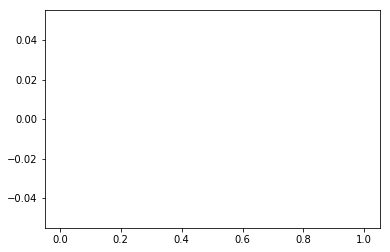

In [45]:
plt.hist(prediction_biased)

In [34]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Predicted probability of being active')
plt.title('Initial and biased probabilities of being active')
plt.legend()
plt.show()

NameError: name 'prediction_biased' is not defined

### Drawing random molecules

Now we will draw some random compounds from the biased library:

In [ ]:
from rdkit.Chem import Draw

In [ ]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [ ]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased]

In [ ]:
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]
sanitized_predictions = [prediction_biased[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [ ]:
len(sanitized_gen_mols)

In [ ]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['P = {sanitized_predictions[i]:0.3f}' for i in ind]

In [ ]:
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)

In [ ]:
thres = 0.80
best_ix = np.where(np.array(sanitized_predictions) >= thres)[0]
best_gen_mols = [sanitized_gen_mols[i] for i in best_ix]
best_predictions = [sanitized_predictions[i] for i in best_ix]

In [ ]:
([np.argsort(best_predictions)][-20:])[0]

In [ ]:
n_to_draw = 20
#ind = [np.argsort(best_predictions)][-n_to_draw:][0]
ind = [np.argsort(best_predictions)][0][-n_to_draw:]

mols_to_draw = [best_gen_mols[i] for i in ind]
legends = [f'P = {best_predictions[i]:0.3f}' for i in ind]

In [ ]:
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)

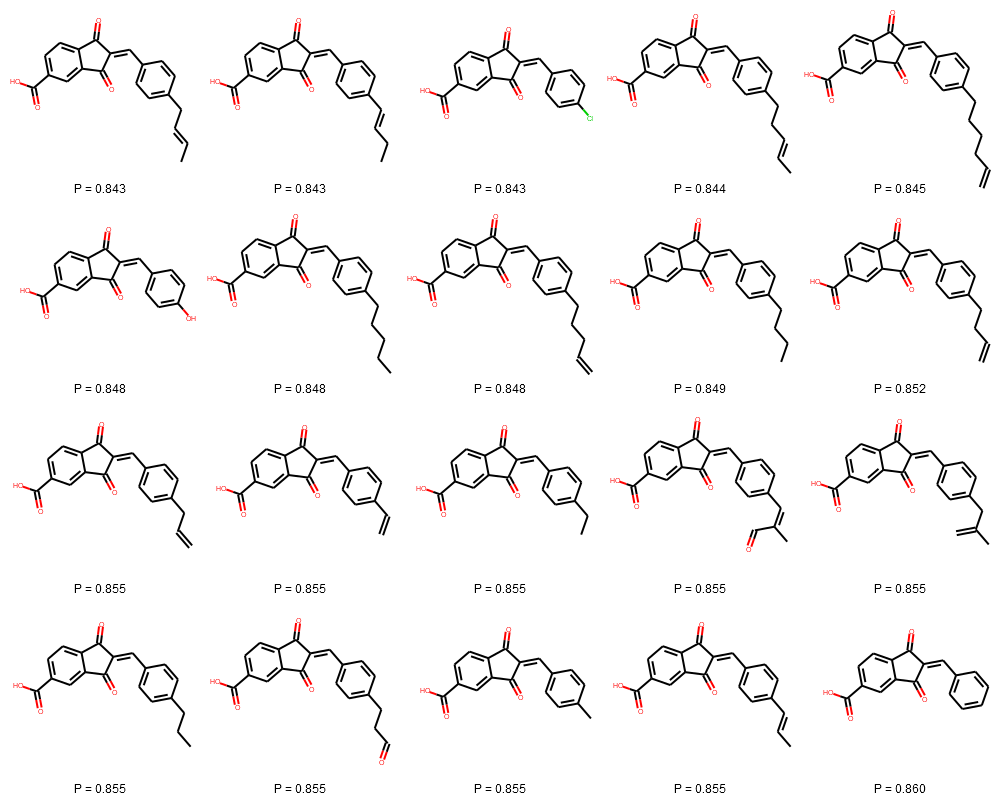

In [108]:
core = mols_to_draw[-1:][0]
Chem.AllChem.Compute2DCoords(core)
for m in mols_to_draw: 
    Chem.AllChem.GenerateDepictionMatching2DStructure(m,core)
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)

In [ ]:
f = open("smiles.smi", 'w')
for sm in smiles_biased:
    f.writelines(sm + '\n')
f.close()

In [ ]:
from release.utils import get_desc

In [ ]:
from mordred

In [ ]:
get_desc(smiles_biased[:10])